In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
from typing import Literal, Tuple, Dict
from dataclasses import dataclass


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 22})
torch.manual_seed(42)
np.random.seed(42)


data_path = Path.cwd().parent / "classification_data"
ett_path = data_path / "ETTh1"
weather_path = data_path / "weather"
exchange_path = data_path / "Exchange"

<h2> Visualizing predictions </h2>

In [2]:
@dataclass
class CLSData:
    x: np.ndarray
    y: np.ndarray
    # error lag is the error for all models on the current input window, meaning the pointwise SE for for the preds shifted by the seq_len
    preds: np.ndarray
    mse: pd.DataFrame
    error_lag: np.ndarray
    best_idx: pd.DataFrame
    id2label: dict
    name: str


def load_cls_data(
    path: Path, 
    split: Literal["train", "test", "val"], 
    name="data", 
    include_mean=False,
    # The models are trained on a certain seq_len, but we can chop of predictions beyond a seq_len if we want to evaluate them on shorter horizons
    seq_len=2) -> CLSData:

    x = np.load(path / f"{split}_inputs.npy")
    assert seq_len <= x.shape[1], f"seq_len {seq_len} is greater than the sequence length of the data {x.shape[1]}"
    y = np.load(path / f"{split}_outputs.npy")
    # mse = np.load(path / f"{split}_mse.npy")
    preds = np.load(path / f"{split}_predictions.npy")

    # x = x[:, :seq_len]
    y = y[:, :seq_len]
    preds = preds[:,:,:seq_len]
    mse = ((y[None, :, :, :] - preds)**2).mean(-2)

    with open(weather_path / "model_order.json") as f:
        id2label = json.load(f)
        id2label = {int(k): v for k, v in id2label.items()}

    if include_mean:
        mean_preds = preds.mean(0)
        mean_mse = ((y - mean_preds)**2).mean(1)
        mse = np.concatenate((mse, mean_mse[None, :]))
        preds = np.concatenate((preds, mean_preds[None, :, :]))
        id2label[len(id2label)] = "Mean"

    best_idx = mse.argmin(0)

    # error lag
    pred_len = y.shape[1]
    preds_shifted = np.roll(preds, pred_len, axis=1)  # [:, seq_len:]
    preds_shifted[:, :pred_len] = 0
    y_shifted = np.roll(y, pred_len, axis=0)  # [seq_len:]
    error_lag = ((preds_shifted - y_shifted)**2)
    # Set the first seq_len of error lag to 0 since they are not defined
    error_lag[:, :pred_len] = 0

    return CLSData(x, y, preds, mse, error_lag, best_idx, id2label, name)

In [3]:
weather_train_data = load_cls_data(weather_path, "train", "Weather train data")
weather_val_data = load_cls_data(weather_path, "val", "Weather val data")
weather_test_data = load_cls_data(weather_path, "test", "Weather test data")
print(f"Weather test data x shape: {weather_test_data.x.shape}")
print(f"Weather test data y shape: {weather_test_data.y.shape}")
print(f"Weather test data preds shape: {weather_test_data.preds.shape}")
print(f"Weather test data error lag shape: {weather_test_data.error_lag.shape}")
print(f"Weather test data best idx shape: {weather_test_data.best_idx.shape}")

Weather test data x shape: (10444, 96, 21)
Weather test data y shape: (10444, 2, 21)
Weather test data preds shape: (7, 10444, 2, 21)
Weather test data error lag shape: (7, 10444, 2, 21)
Weather test data best idx shape: (10444, 21)


In [4]:
weather_train_data.id2label

{0: 'Crossformer',
 1: 'DLinear',
 2: 'PatchTST',
 3: 'TimeMixer',
 4: 'TimeXer',
 5: 'TimesNet',
 6: 'iTransformer'}

In [5]:
def filter_cls_data_models(cls_data: CLSData, models: list[str]) -> CLSData:
    idx = [k for k, v in cls_data.id2label.items() if v in models]
    preds_filtered = cls_data.preds[idx]
    mse_filtered = cls_data.mse[idx]
    error_lag_filtered = cls_data.error_lag[idx]
    best_idx_filtered = mse_filtered.argmin(axis=0)
    id2label_filtered = {
        i: cls_data.id2label[old_idx] for i, old_idx in enumerate(idx)}

    return CLSData(
        x=cls_data.x,
        y=cls_data.y,
        preds=preds_filtered,
        mse=mse_filtered,
        error_lag=error_lag_filtered,
        best_idx=best_idx_filtered,
        id2label=id2label_filtered,
        name=cls_data.name
    )

In [6]:
def vizualize_error_residual(cls_data: CLSData, slice_idx: int, feature_idx: int, model_a_idx: int, model_b_idx: int):
    # Show input series, x, error lag, future y, and preds for the models on y
    
    # lag_slice = cls_data.error_lag[:, slice_idx, :, feature_idx]
    # x_slice = cls_data.x[slice_idx, :, feature_idx]
    y_slice = cls_data.y[slice_idx, :, feature_idx]
    preds_slice = cls_data.preds[:, slice_idx, :, feature_idx]
    errs = cls_data.error_lag[:, slice_idx+len(y_slice), :, feature_idx]

    preds_slice_a = preds_slice[model_a_idx]
    preds_slice_b = preds_slice[model_b_idx]
    errs_a = errs[model_a_idx]
    errs_b = errs[model_b_idx]
    err_residual = errs_a - errs_b

    plt.plot(y_slice, label="GT")
    # plt.plot(t_past, lag_slice[model_idx], label=f"Error lags {model_name}")
    plt.plot(preds_slice_a, label=f"Preds {model_a_idx}")
    plt.plot(preds_slice_b, label=f"Preds {model_b_idx}")
    plt.plot(err_residual, label=f"Errs residual {model_a_idx} - {model_b_idx}")
    plt.legend(
        loc='upper left',        
        bbox_to_anchor=(0, 1),   
        ncol=3,            
        fontsize='small',   
        frameon=True,    
        framealpha=0.9   
    )
    plt.show()
    

# vizualize_error_residual(weather_test_data, 3*96, 10, 0, 1)

In [7]:
# # only TimeXer and DLinear
# weather_train_data = filter_cls_data_models(
#     weather_train_data, ["TimeXer", "PatchTST", "DLinear", "TimeMixer   "])
# weather_val_data = filter_cls_data_models(
#     weather_val_data, ["TimeXer", "PatchTST", "DLinear", "TimeMixer"])
# weather_test_data = filter_cls_data_models(
#     weather_test_data, ["TimeXer", "PatchTST", "DLinear", "TimeMixer"])
# weather_test_data.x.shape, weather_test_data.y.shape, weather_test_data.preds.shape, weather_test_data.mse.shape, weather_test_data.best_idx.shape

In [8]:
ett_train_data = load_cls_data(ett_path, "train", "ETTh train data")
ett_val_data = load_cls_data(ett_path, "val", "ETTh val data")
ett_test_data = load_cls_data(ett_path, "test", "ETTh test data")
ett_test_data.x.shape, ett_test_data.y.shape, ett_test_data.preds.shape, ett_test_data.mse.shape, ett_test_data.best_idx.shape

((2785, 96, 7), (2785, 2, 7), (7, 2785, 2, 7), (7, 2785, 7), (2785, 7))

In [9]:
exchange_train_data = load_cls_data(exchange_path, "train", "Exchange train data")
exchange_val_data = load_cls_data(exchange_path, "val", "Exchange val data")
exchange_test_data = load_cls_data(exchange_path, "test", "Exchange test data")
exchange_test_data.x.shape, exchange_test_data.y.shape, exchange_test_data.preds.shape, exchange_test_data.mse.shape, exchange_test_data.best_idx.shape

((1422, 96, 8), (1422, 2, 8), (7, 1422, 2, 8), (7, 1422, 8), (1422, 8))

In [10]:
weather_test_data.id2label

{0: 'Crossformer',
 1: 'DLinear',
 2: 'PatchTST',
 3: 'TimeMixer',
 4: 'TimeXer',
 5: 'TimesNet',
 6: 'iTransformer'}

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def plot_slice_preds(cls_data: CLSData, slice_idx, feature_idx=0):
    inp = cls_data.x[slice_idx, :, feature_idx]
    out = cls_data.y[slice_idx, :, feature_idx]
    preds = cls_data.preds[:, slice_idx, :, feature_idx]
    mse_per_model = ((preds - out)**2).mean(axis=1)

    best_idx = cls_data.best_idx[slice_idx, feature_idx]
    best_model = cls_data.id2label[best_idx]

    t_in = np.arange(len(inp))
    t_out = np.arange(len(inp), len(inp) + len(out))

    plt.figure()
    plt.plot(t_in, inp, color='tab:gray', linewidth=2, label='Input (history)')
    plt.axvline(x=len(inp)-0.5, color='black', linestyle='--',
                alpha=0.7, label='Forecast start')
    plt.plot(t_out, out, color='tab:green', linewidth=3,
             label='Ground truth', solid_capstyle='butt')

    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for i in range(preds.shape[0]):
        label = f'{cls_data.id2label[i]} (MSE = {mse_per_model[i]:.4f})'
        plt.plot(t_out, preds[i], color=colors[i], linestyle='--', linewidth=2,
                 label=label, alpha=0.9)

    plt.xlabel('Time step')
    plt.ylabel(f'Feature {feature_idx}')
    plt.title(
        f'{cls_data.name}, slice {slice_idx}, feature {feature_idx}, best model {best_model}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

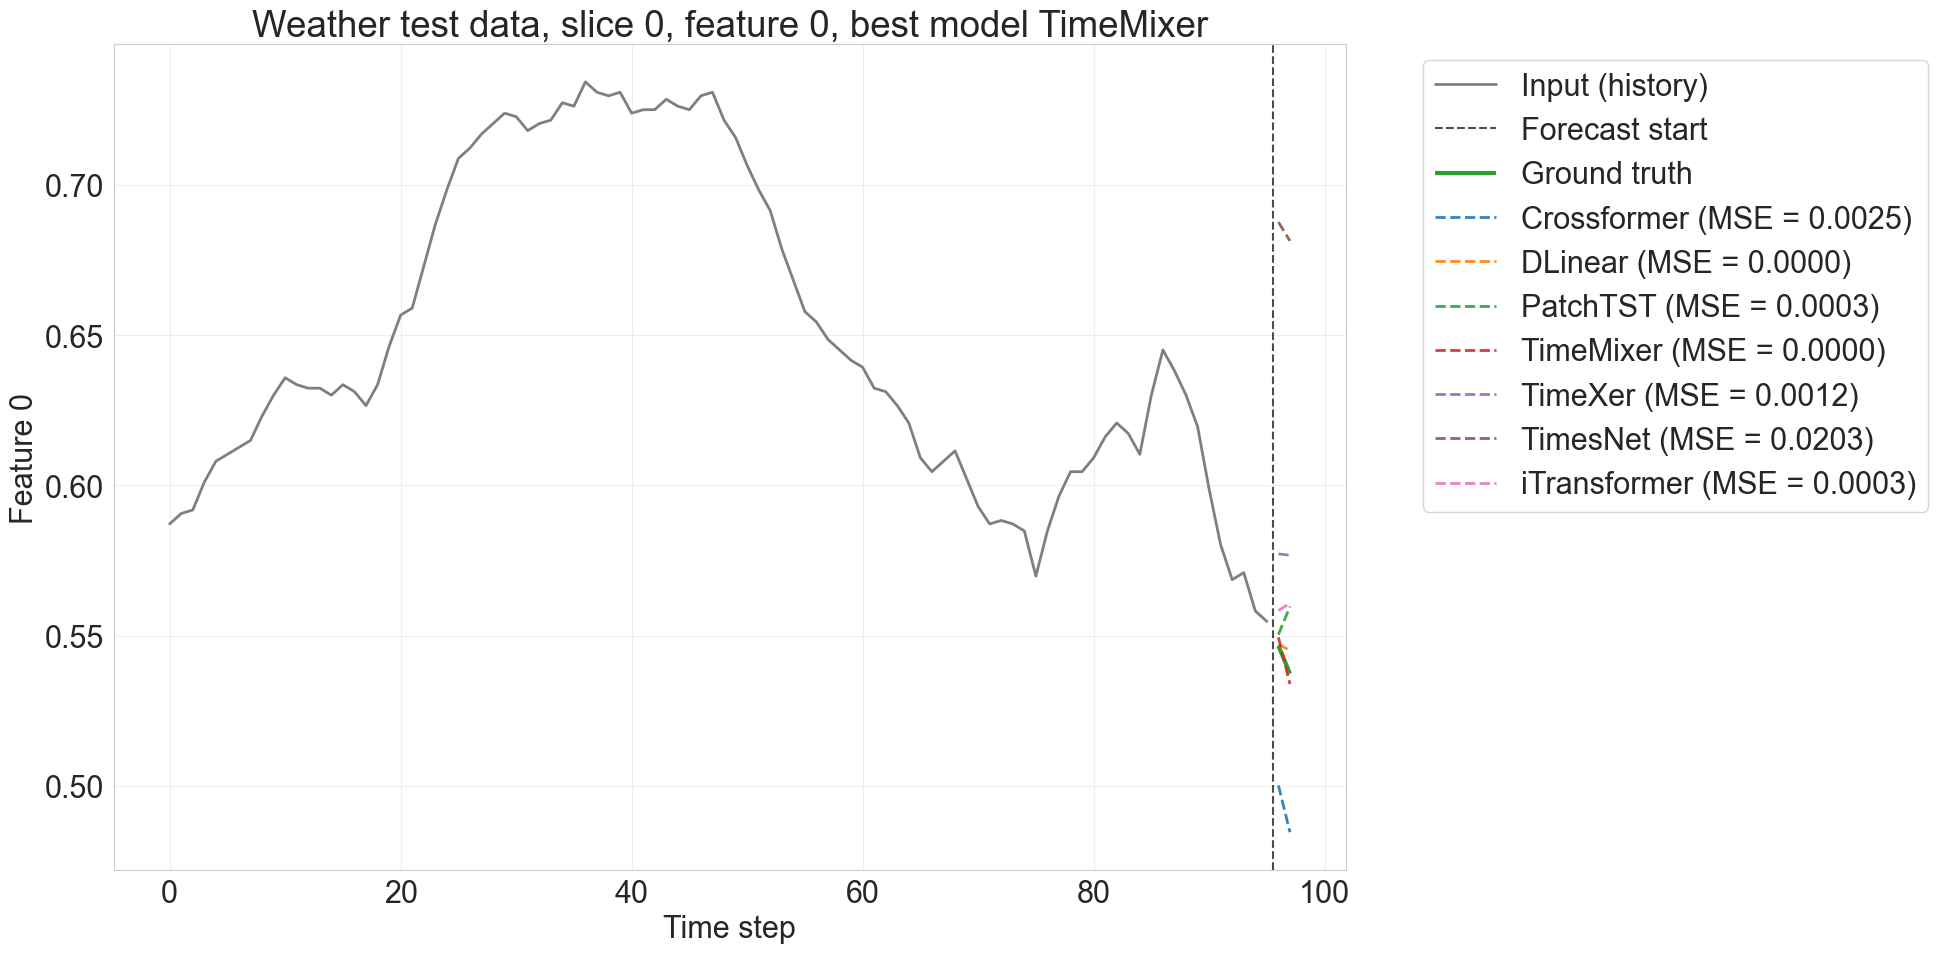

In [12]:
plot_slice_preds(weather_test_data, 0, 0)

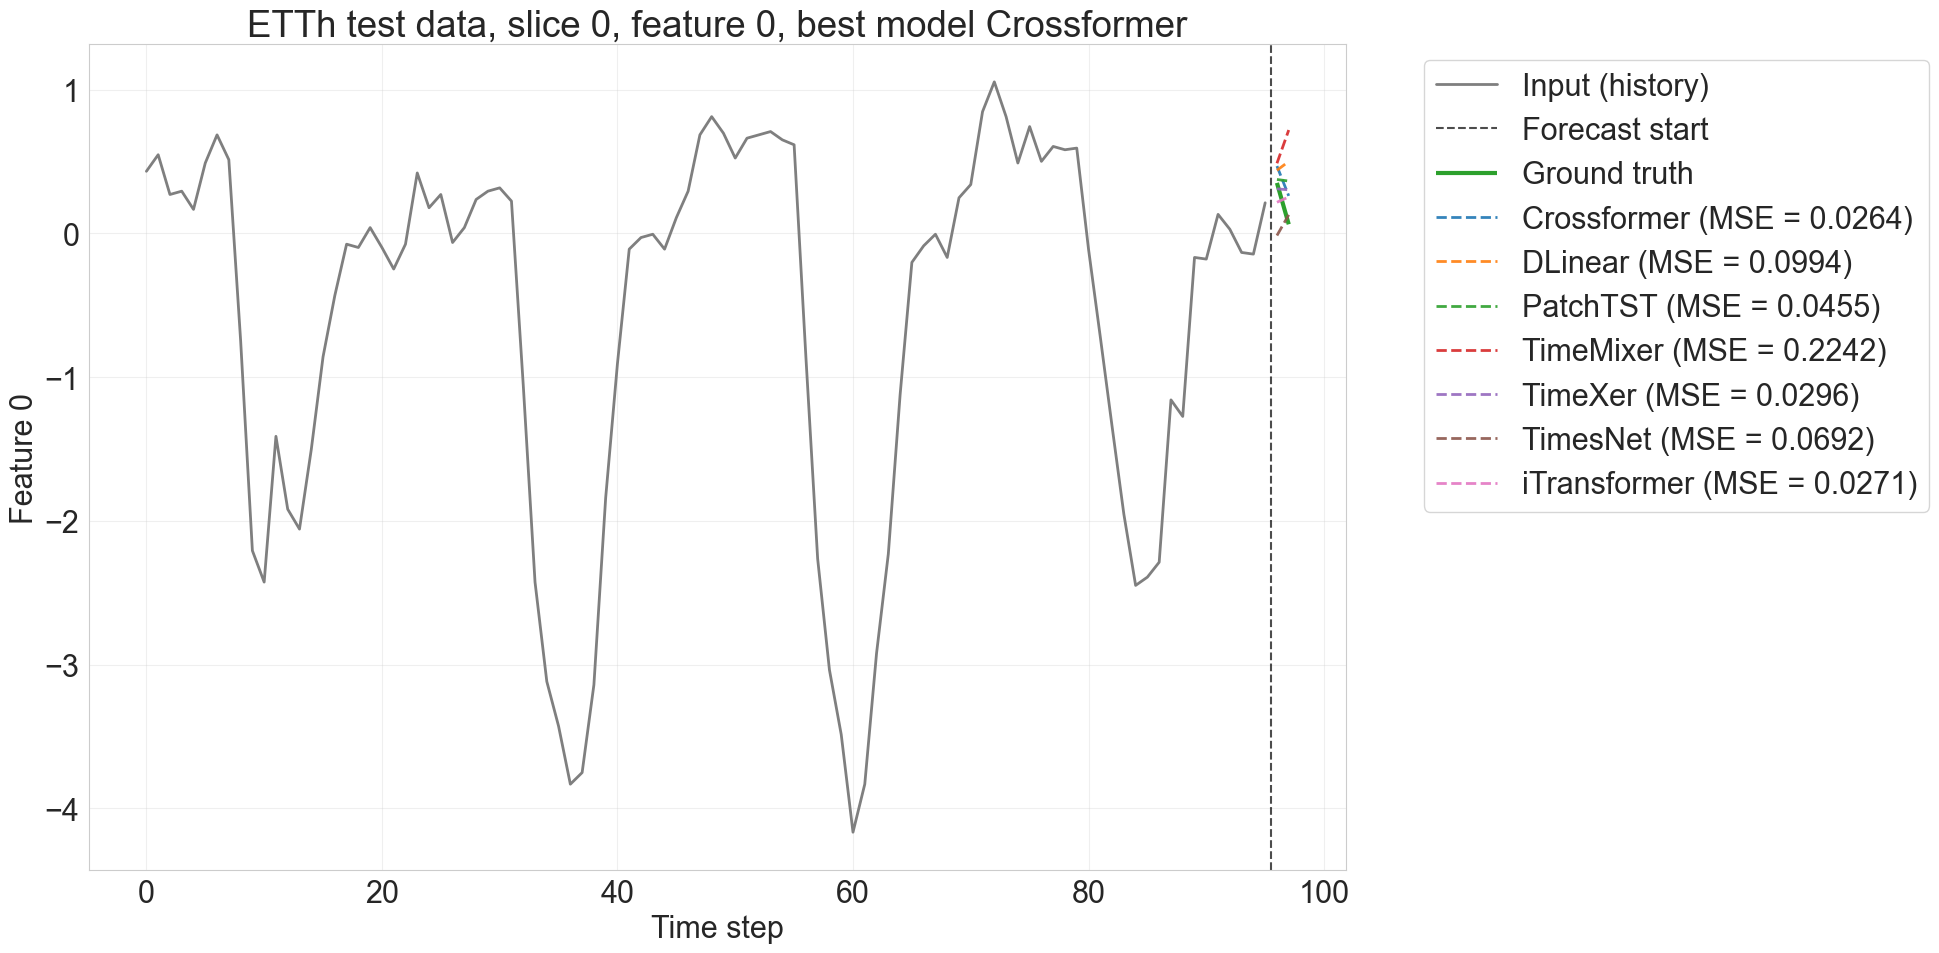

In [13]:
plot_slice_preds(ett_test_data, 0, 0)

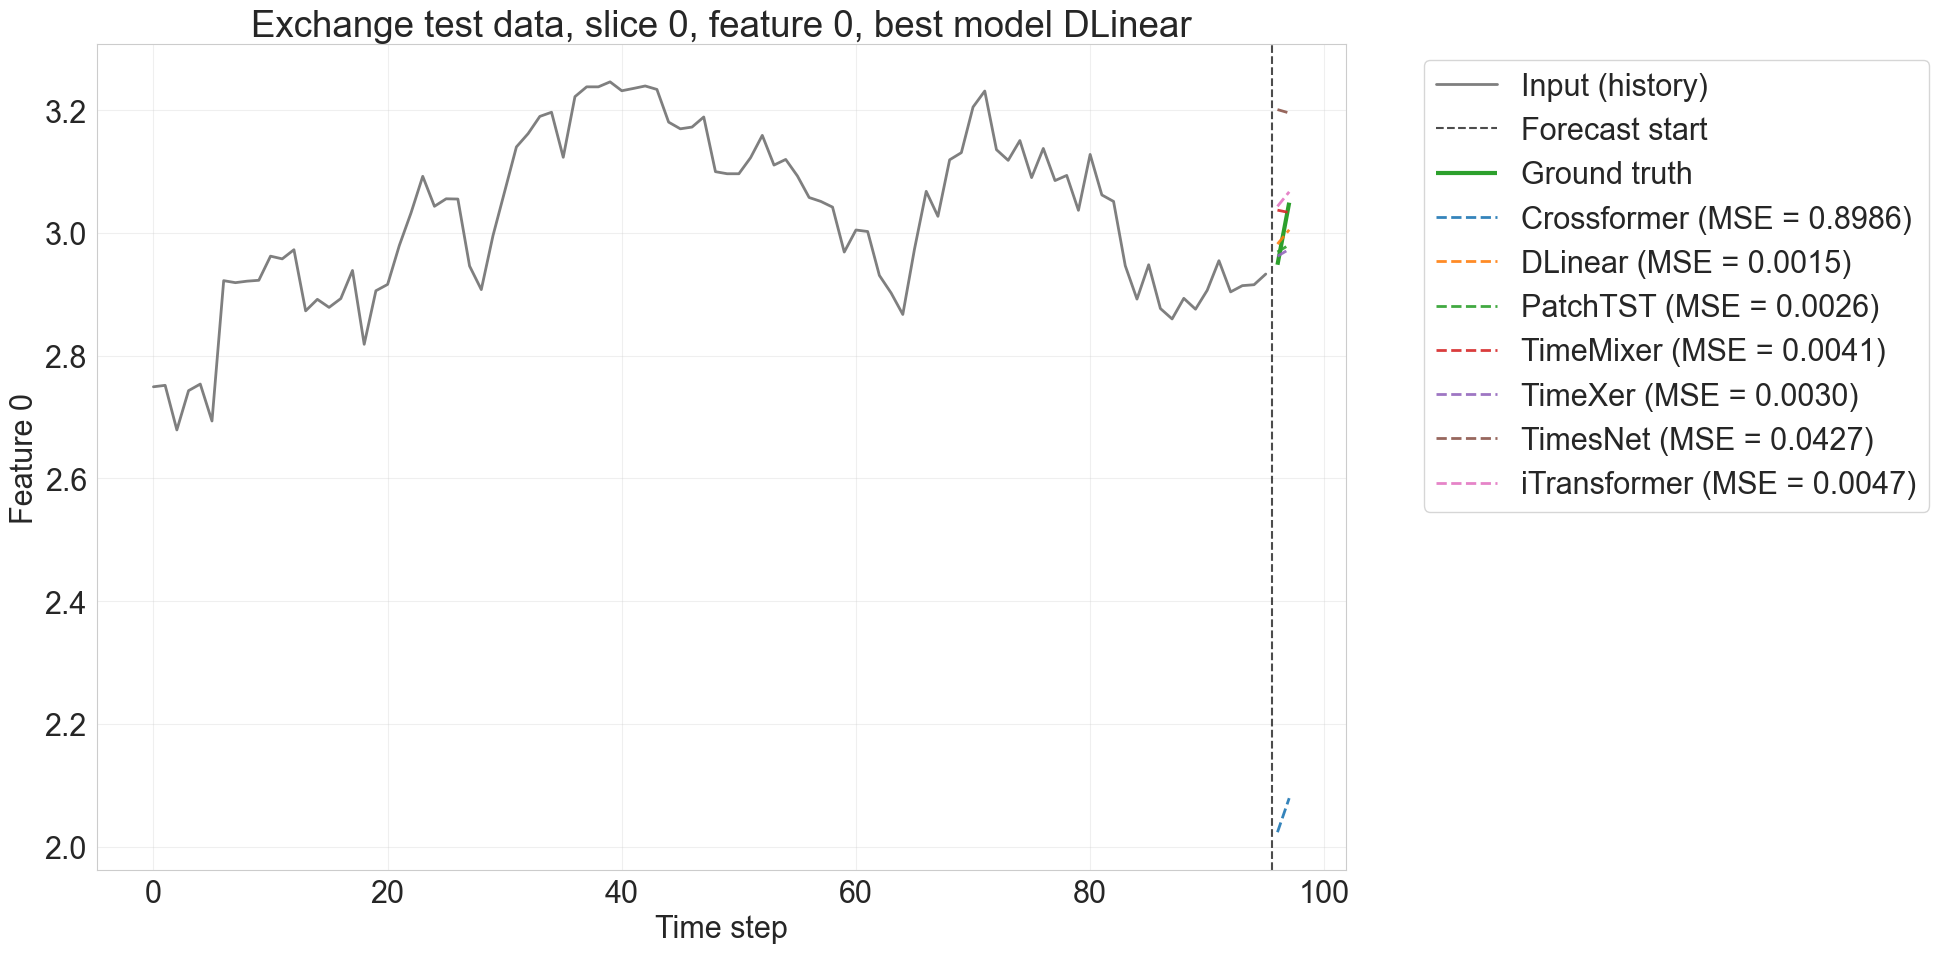

In [14]:
plot_slice_preds(exchange_test_data, 0, 0)

In [15]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image, display


def gif_forecasts(cls_data: CLSData, feature_idx=0, fps=5, max_frames=250):
    n_slices = cls_data.x.shape[0]
    frames = min(n_slices, max_frames)
    indices = np.linspace(0, n_slices - 1, frames, dtype=int)

    inp_all = cls_data.x[:, :, feature_idx]
    out_all = cls_data.y[:, :, feature_idx]
    preds_all = cls_data.preds[:, :, :, feature_idx]
    mse_all = ((preds_all - out_all) ** 2).mean(axis=2)

    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    fig = plt.figure()
    ax = fig.add_axes([0.12, 0.12, 0.60, 0.76])

    def animate(i):
        ax.clear()

        slice_idx = indices[i]
        inp = inp_all[slice_idx]
        out = out_all[slice_idx]
        preds = preds_all[:, slice_idx, :]
        mse_per_model = mse_all[:, slice_idx]

        best_idx = cls_data.best_idx[slice_idx, feature_idx]
        best_model = cls_data.id2label[best_idx]

        t_in = np.arange(len(inp))
        t_out = np.arange(len(inp), len(inp) + len(out))

        ax.plot(t_in, inp, color='tab:gray',
                linewidth=2, label='Input (history)')
        ax.axvline(len(inp) - 0.5, color='black', linestyle='--', alpha=0.7)
        ax.plot(t_out, out, color='tab:green', linewidth=3,
                label='Ground truth', solid_capstyle='butt')

        for j in range(preds.shape[0]):
            label = f'{cls_data.id2label[j]} (MSE = {mse_per_model[j]:.4f})'
            ax.plot(t_out, preds[j], color=colors[j], linestyle='--', linewidth=2,
                    label=label, alpha=0.9)

        ax.set_xlabel('Time step')
        ax.set_ylabel(f'Feature {feature_idx}')
        ax.set_title(
            f'Slice {slice_idx} – Feature {feature_idx}\nBest model: {best_model}')
        ax.grid(True, alpha=0.3)

        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    anim = animation.FuncAnimation(
        fig, animate, frames=frames, interval=1000//fps)
    anim.save('forecasts.gif', writer=PillowWriter(fps=fps), dpi=110)
    plt.close(fig)
    display(Image('forecasts.gif'))

In [16]:
# gif_forecasts(weather_test_data, feature_idx=0, max_frames=300)

In [17]:
# gif_forecasts(ett_test_data, feature_idx=0, max_frames=300)

In [18]:
# gif_forecasts(exchange_test_data, feature_idx=0, max_frames=300)

<h2> Summarizing performance: Global and per-slice </h2>

In [19]:
def add_model_to_cls_data(preds: np.ndarray, model_name: str, cls_data: CLSData) -> CLSData:
    new_preds = np.concatenate((preds[None, :, :], cls_data.preds), axis=0)

    new_model_mse = ((cls_data.y - preds) ** 2).mean(axis=1)
    new_mse = np.concatenate((new_model_mse[None, :], cls_data.mse), axis=0)

    new_best_idx = new_mse.argmin(axis=0)

    # Since adding Oracle post-hoc, error_lag has no real meaning
    # Just pad with zeros to keep shape consistent
    zero_lag = np.zeros((1, *cls_data.error_lag.shape[1:]))
    new_error_lag = np.concatenate((zero_lag, cls_data.error_lag), axis=0)

    new_id2label = {k + 1: v for k, v in cls_data.id2label.items()}
    new_id2label[0] = model_name

    return CLSData(
        cls_data.x,
        cls_data.y,
        new_preds,
        new_mse,
        new_error_lag,
        new_best_idx,
        new_id2label,
        f"{cls_data.name} + {model_name}"
    )

def select_preds_from_idx(idx: np.ndarray, preds: np.ndarray):
    _, _, n_time, _ = preds.shape
    idx_reshaped = idx[np.newaxis, :, np.newaxis, :]
    A_broadcastable = np.repeat(idx_reshaped, n_time, axis=2)
    result_take = np.take_along_axis(preds, A_broadcastable, axis=0)
    output = np.squeeze(result_take, axis=0)
    return output

In [20]:
import matplotlib.cm as cm


def print_metrics_matrix(cls_data: CLSData, include_oracle=True, plot=True) -> str:
    if include_oracle:
        oracle_preds = select_preds_from_idx(cls_data.best_idx, cls_data.preds)
        cls_data = add_model_to_cls_data(oracle_preds, "Oracle", cls_data)

    mse = ((cls_data.y[None, :, :, :]-cls_data.preds)**2).mean(axis=(1, 2, 3))
    mae = (np.abs(cls_data.y[None, :, :, :] -
           cls_data.preds)).mean(axis=(1, 2, 3))
    id2label = cls_data.id2label

    header = f"{'Model':<15} {'MSE':>10} {'MAE':>10}"
    sep = "-"*37
    lines = [header, sep]

    idx_sorted = mse.argsort()
    for i in idx_sorted:
        name = id2label[i]
        lines.append(f"{name:<15} {mse[i]:10.4f} {mae[i]:10.4f}")

    print("\n".join([cls_data.name + " metrics"] + lines))

    if plot:
        n_models = len(idx_sorted)
        colors = cm.tab20(range(n_models))
        _, ax = plt.subplots()
        models = [id2label[i] for i in idx_sorted[::-1]]
        mse_values = [mse[i] for i in idx_sorted[::-1]]

        ax.barh(models, mse_values, color=colors[::-1])
        ax.set_xlabel("Average Test MSE")
        ax.set_ylabel("Model")
        ax.set_title(f"{cls_data.name}: Forecasting Model Performance")
        plt.tight_layout()
        plt.show()

Weather test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.0255     0.0359
TimeXer             0.0416     0.0603
TimeMixer           0.0423     0.0622
PatchTST            0.0454     0.0670
iTransformer        0.0470     0.0722
DLinear             0.0482     0.0847
TimesNet            0.0765     0.1236
Crossformer         0.0826     0.1388


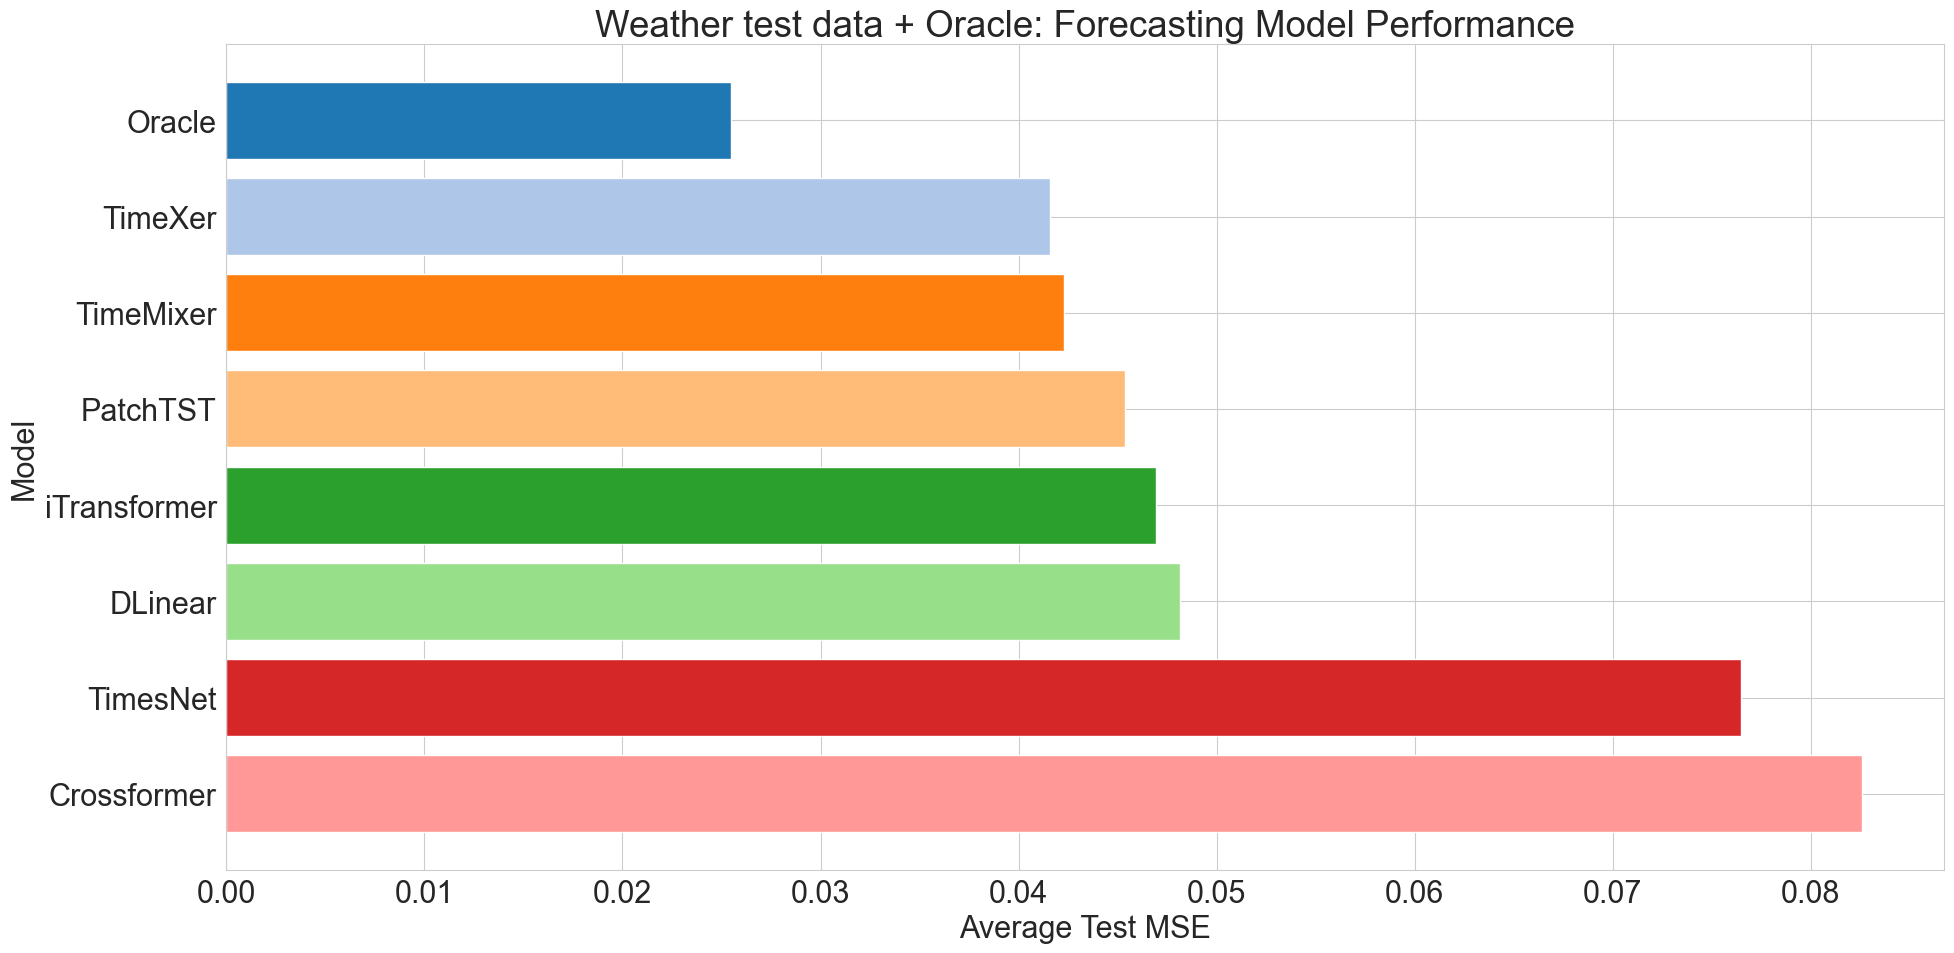

ETTh test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.0739     0.1585
TimeXer             0.1404     0.2485
PatchTST            0.1427     0.2492
TimeMixer           0.1515     0.2581
iTransformer        0.1907     0.2905
DLinear             0.2052     0.2999
Crossformer         0.2211     0.3315
TimesNet            0.3001     0.3655


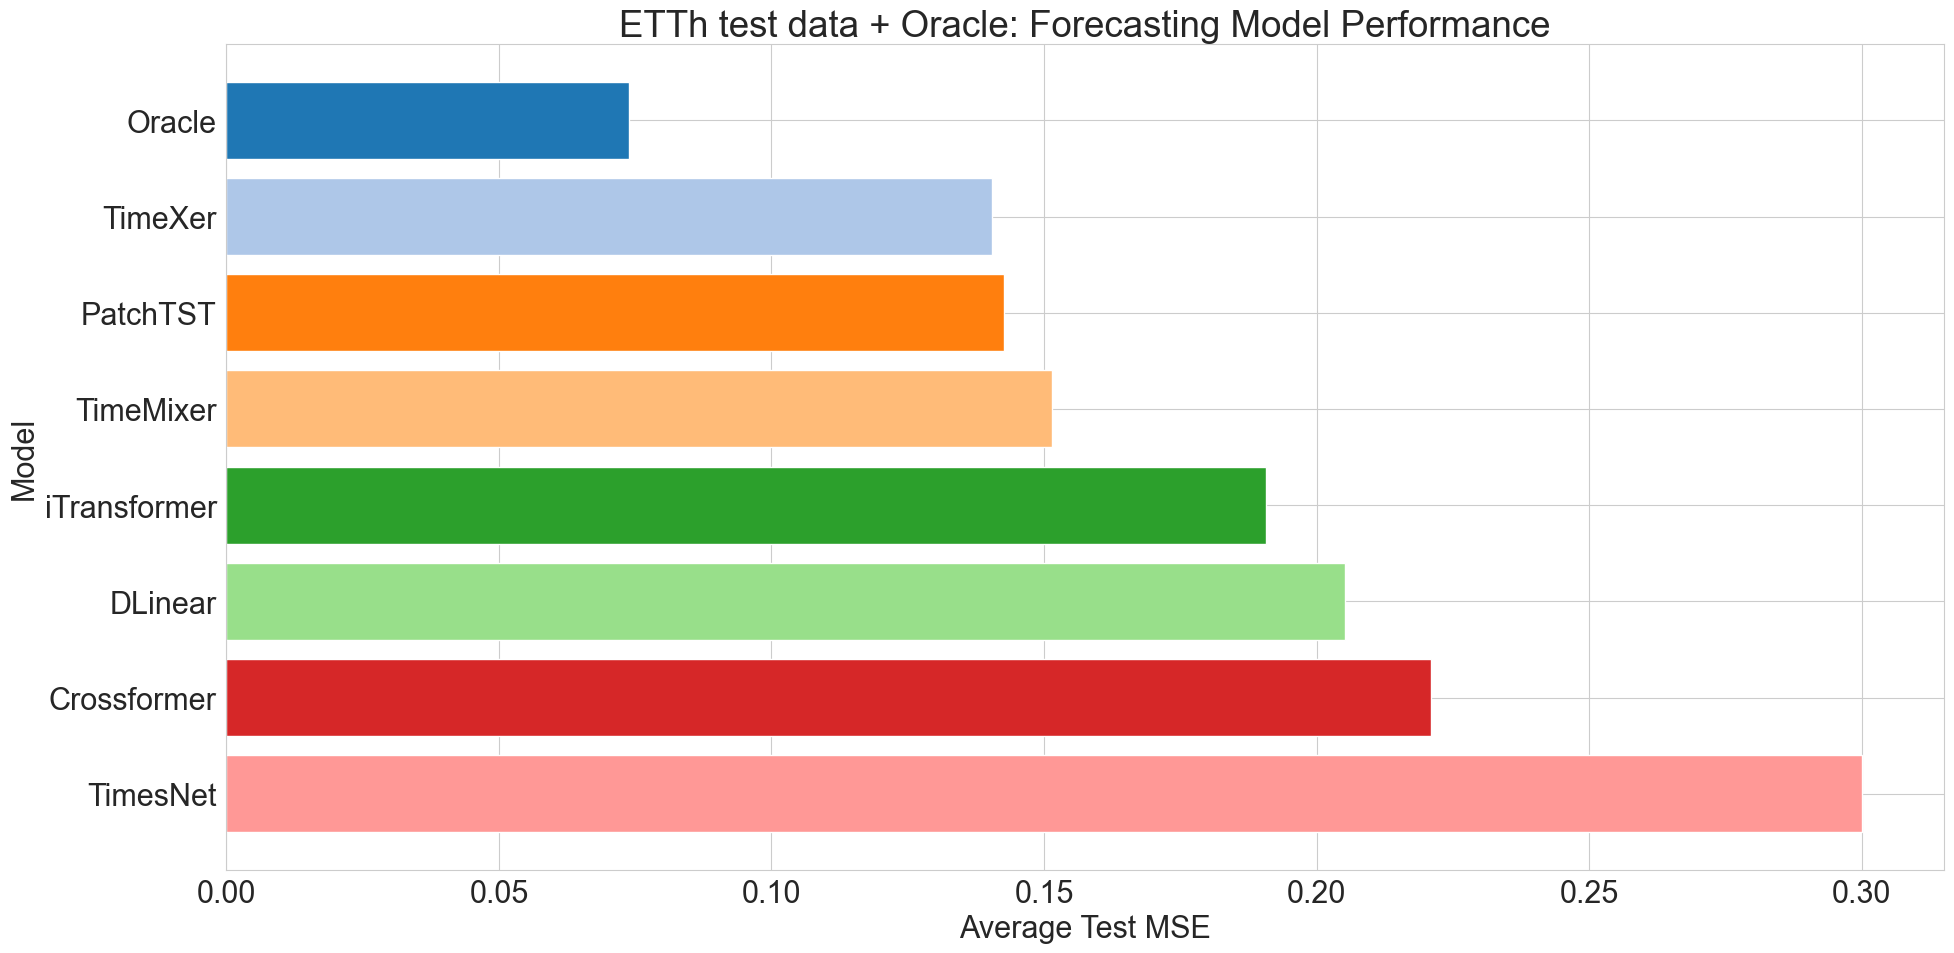

Exchange test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.0029     0.0270
PatchTST            0.0063     0.0495
TimeXer             0.0084     0.0593
iTransformer        0.0092     0.0636
TimeMixer           0.0115     0.0734
DLinear             0.0181     0.0951
TimesNet            0.0242     0.1089
Crossformer         0.2514     0.3282


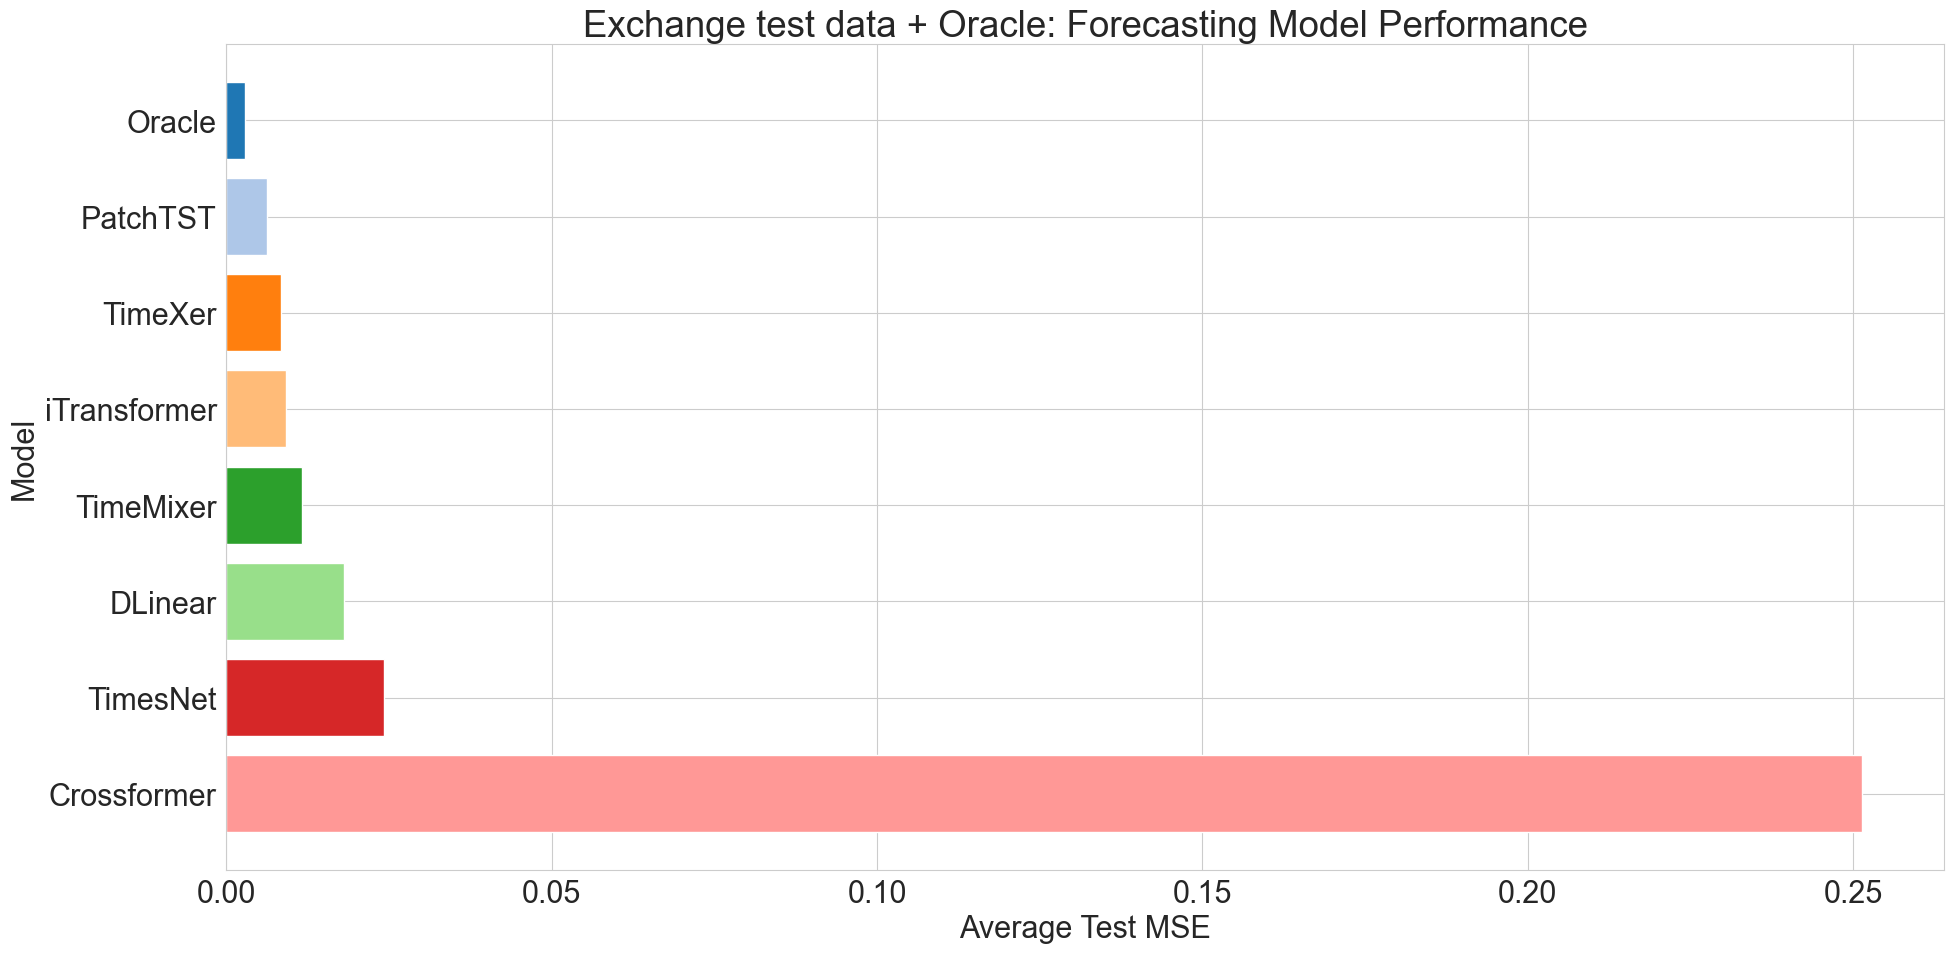

In [21]:
print_metrics_matrix(weather_test_data)
print_metrics_matrix(ett_test_data)
print_metrics_matrix(exchange_test_data)

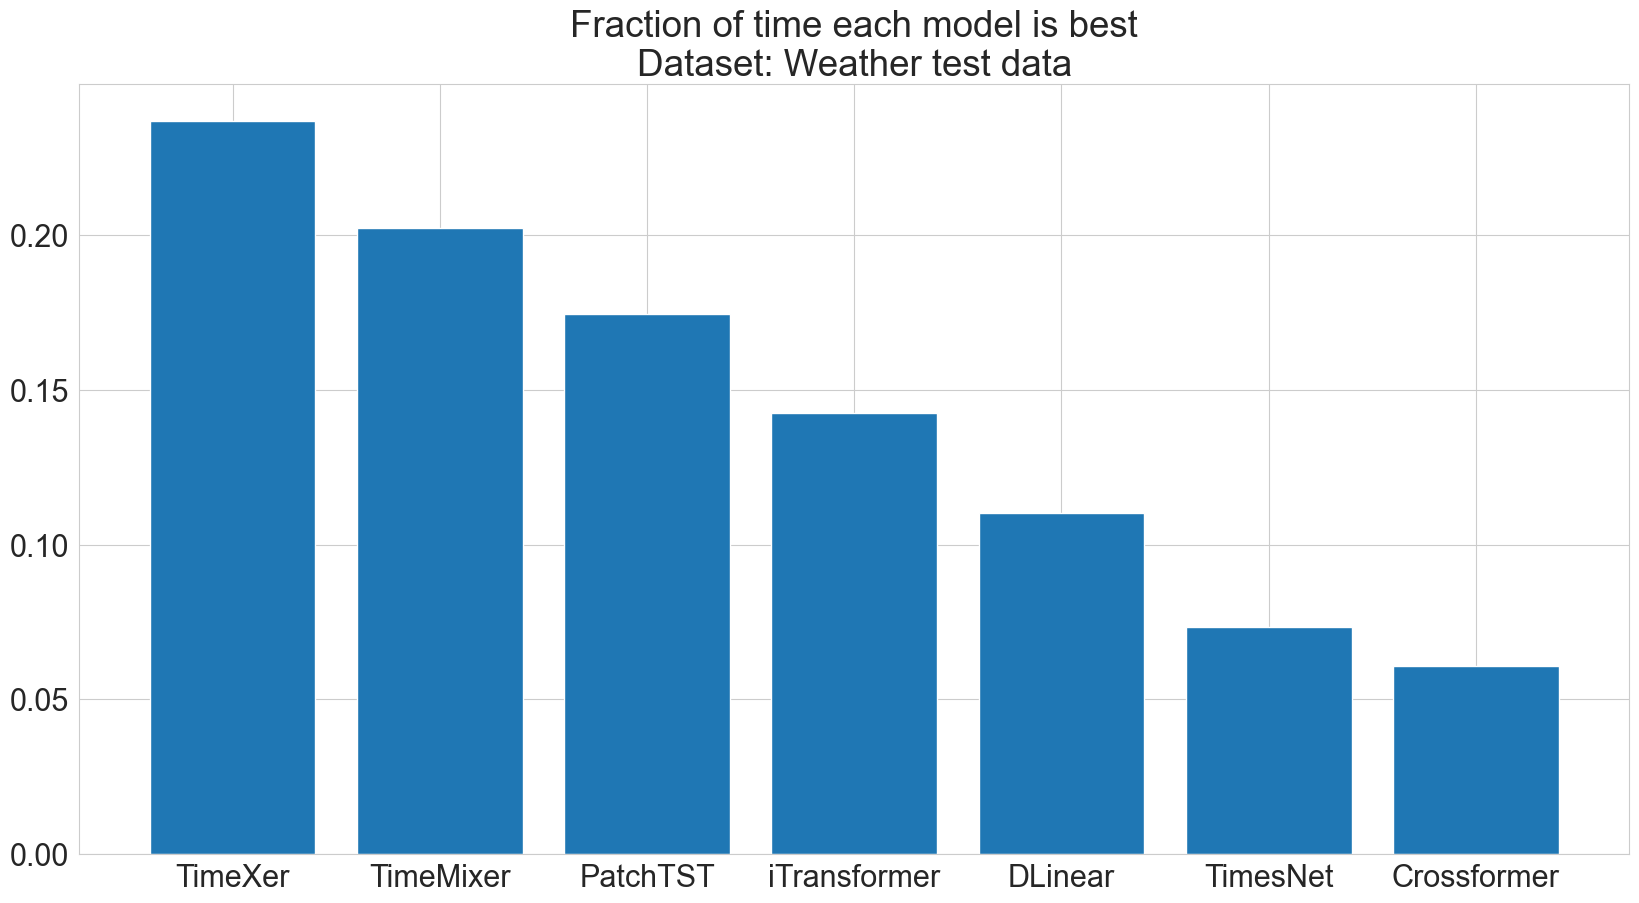

In [22]:
def plot_mse_per_slice(cls_data: CLSData) -> None:
    mse = cls_data.mse
    top_mse = np.argmin(mse.reshape(len(mse), -1), axis=0)
    vals, counts = np.unique(top_mse, return_counts=True)
    fracs = counts / len(top_mse)
    sort_idx = np.argsort(-fracs)
    vals = vals[sort_idx]
    fracs = fracs[sort_idx]
    labels = [cls_data.id2label[i] for i in vals]
    plt.title(f"Fraction of time each model is best\nDataset: {cls_data.name}")
    plt.bar(labels, fracs)
    plt.show()

plot_mse_per_slice(weather_test_data)
# plot_mse_per_slice(ett_test_data)
# plot_mse_per_slice(exchange_test_data)

<h2> Classifying the best model with lag heuristics</h2>

<h3> Most recent best </h3>

====VAL REPORT====
              precision    recall  f1-score   support

           0       0.26      0.26      0.26      6276
           1       0.38      0.38      0.38     14445
           2       0.37      0.37      0.37     18734
           3       0.40      0.40      0.40     21740
           4       0.44      0.44      0.44     23277
           5       0.22      0.22      0.22      8535
           6       0.33      0.33      0.33     15668

    accuracy                           0.37    108675
   macro avg       0.34      0.34      0.34    108675
weighted avg       0.37      0.37      0.37    108675



====TEST REPORT====
              precision    recall  f1-score   support

           0       0.30      0.30      0.30     13342
           1       0.39      0.39      0.39     24166
           2       0.37      0.37      0.37     38287
           3       0.41      0.41      0.41     44318
           4       0.48      0.48      0.48     51934
           5       0.23      0.23    

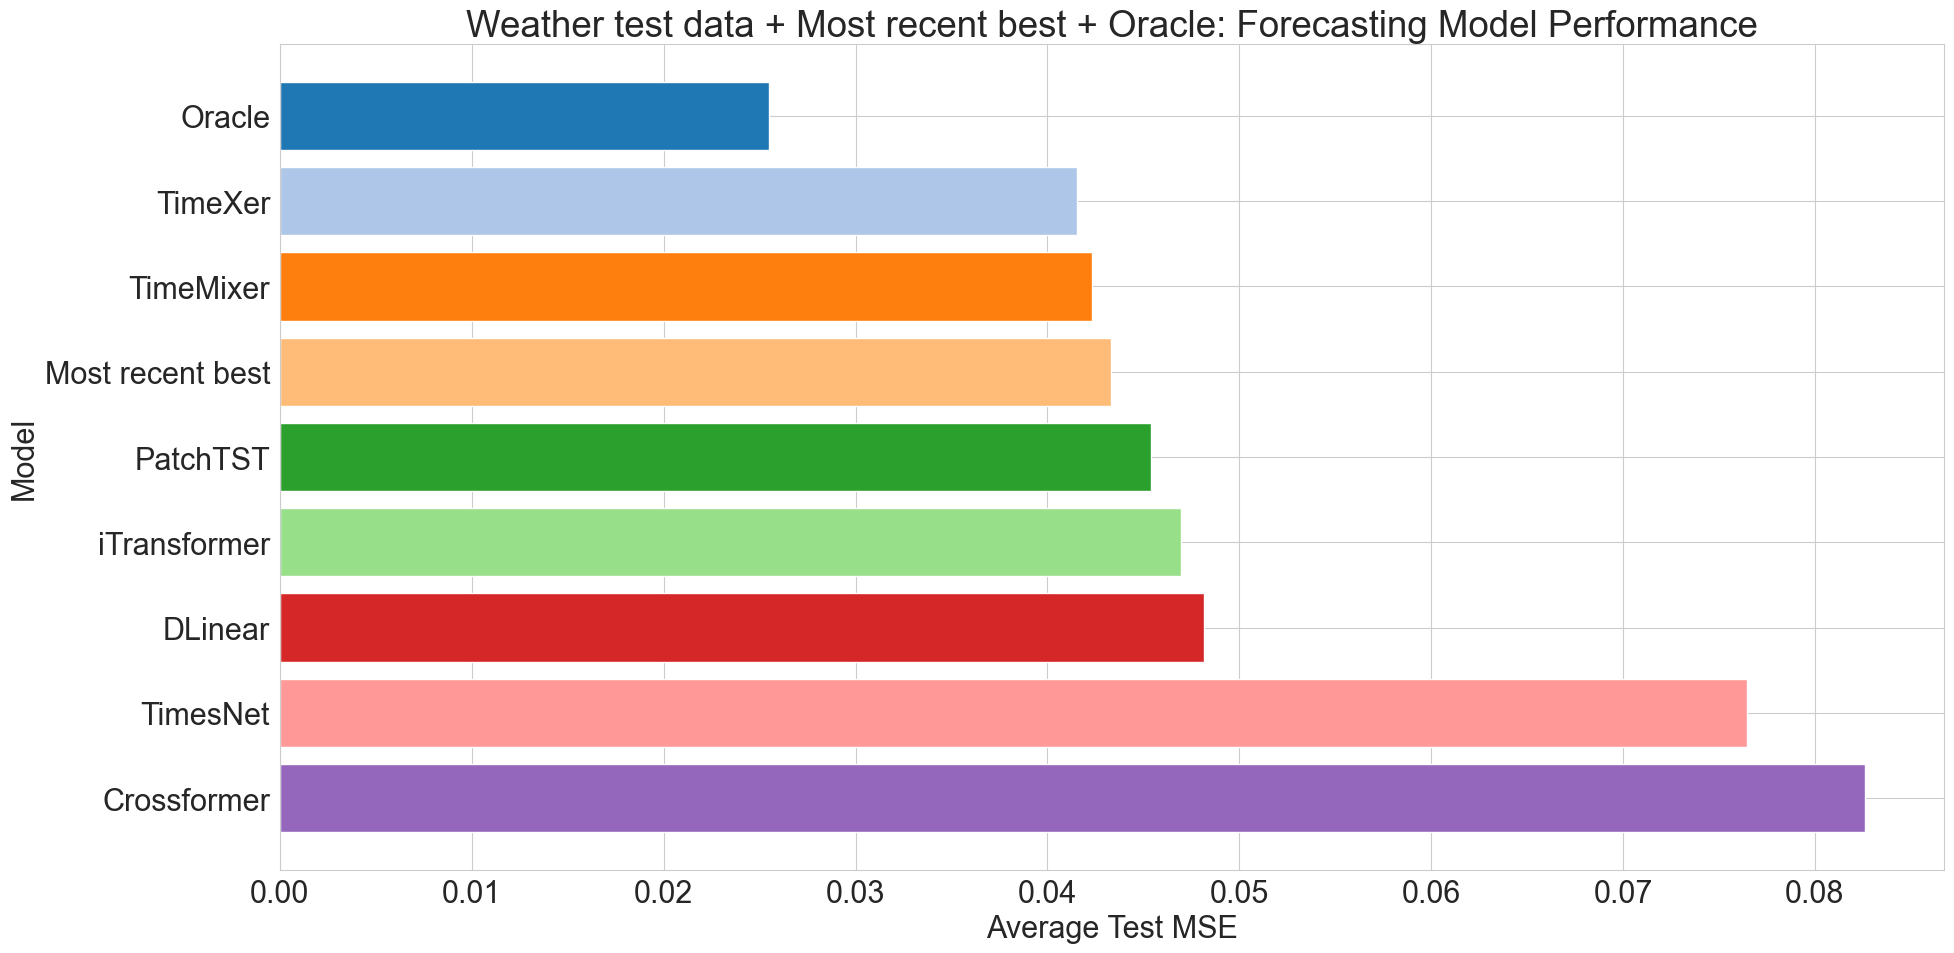

In [23]:
from sklearn.metrics import classification_report

@dataclass
class CLSOutput:
    predicted_best: np.ndarray
    routed_forecasts: np.ndarray


def top_k_acc(y_true, probas, k):
    top_k = np.argsort(probas, axis=1)[:, -k:][:, ::-1]
    return np.mean(np.any(top_k == y_true[:, None], axis=1))


def run_classify_with_most_recent_best(
    train_data: CLSData,
    val_data: CLSData,
    test_data: CLSData
) -> CLSOutput:
    # argmin models for each error lag
    # use result as idx into preds

    predict = lambda el: np.argmin(el.mean(-2), axis=0).astype(np.int64)
    val_best_idx_pred = predict(val_data.error_lag)
    test_best_idx_pred = predict(test_data.error_lag)
    val_report = classification_report(val_data.best_idx.flatten(), val_best_idx_pred.flatten())
    test_report = classification_report(test_data.best_idx.flatten(), test_best_idx_pred.flatten())
    print(f"====VAL REPORT====\n{val_report}\n\n")
    print(f"====TEST REPORT====\n{test_report}\n\n")

    test_preds = select_preds_from_idx(test_best_idx_pred, test_data.preds)
    return CLSOutput(predicted_best=test_best_idx_pred, routed_forecasts=test_preds)


most_recent_best_output_weather = run_classify_with_most_recent_best(
    weather_train_data, weather_val_data, weather_test_data
)
weather_test_data_with_most_recent_best = add_model_to_cls_data(
    most_recent_best_output_weather.routed_forecasts, "Most recent best", weather_test_data)
print_metrics_matrix(weather_test_data_with_most_recent_best)

<h3> Best on most similar pattern </h3>

<h2> Classifying the best model with Rocket</h2>

In [24]:
from sktime.classification.kernel_based import RocketClassifier


def run_rocket(
    train_data: CLSData,
    val_data: CLSData,
    test_data: CLSData,
    include_error_lag: bool = False
) -> Tuple[CLSOutput, CLSOutput, CLSOutput]:

    def _prepare_cls_data(cls_data: CLSData):
        n_slices, seq_len, n_feats = cls_data.x.shape
        if include_error_lag:
            x_rs = cls_data.x.reshape(n_slices*n_feats, 1, seq_len)
            err_rs = cls_data.error_lag.reshape(n_slices*n_feats, -1, seq_len)
            error_residual = (err_rs[:, 0] - err_rs[:, 1])
            error_residual = error_residual.reshape(n_slices*n_feats, 1, seq_len)
            x_rs = np.concatenate((x_rs, error_residual), 1)
            # x_rs = err_rs
            idx_rs = cls_data.best_idx.flatten()
        else:
            x_rs = cls_data.x.transpose(0, 2, 1).reshape(
                n_slices*n_feats, seq_len)
            idx_rs = cls_data.best_idx.reshape(n_slices*n_feats)
        return x_rs, idx_rs

    rocket = RocketClassifier(num_kernels=100)
    X_train, y_train = _prepare_cls_data(train_data)
    print(X_train.shape, y_train.shape)
    rocket.fit(X_train, y_train)

    X_val, y_val = _prepare_cls_data(val_data)
    X_test, y_test = _prepare_cls_data(test_data)
    val_preds = rocket.predict(X_val)
    test_preds = rocket.predict(X_test)

    val_probas = rocket.predict_proba(X_val)
    test_probas = rocket.predict_proba(X_test)

    print(f"Val Top-1: {top_k_acc(y_val, val_probas, 1):.4f} | "
          f"Top-2: {top_k_acc(y_val, val_probas, 2):.4f} | "
          f"Top-3: {top_k_acc(y_val, val_probas, 3):.4f}")

    print(f"Test Top-1: {top_k_acc(y_test, test_probas, 1):.4f} | "
          f"Top-2: {top_k_acc(y_test, test_probas, 2):.4f} | "
          f"Top-3: {top_k_acc(y_test, test_probas, 3):.4f}")

    val_report = classification_report(y_val, val_preds)
    test_report = classification_report(y_test, test_preds)

    def _create_cls_output(preds: np.ndarray, cls_data: CLSData):
        n_slices, _, n_feats = cls_data.x.shape
        predicted_best_idx = preds.reshape(n_slices, n_feats)
        routed_forecasts = select_preds_from_idx(
            predicted_best_idx, cls_data.preds)
        return CLSOutput(predicted_best_idx, routed_forecasts)

    val_output = _create_cls_output(val_preds, val_data)
    test_output = _create_cls_output(test_preds, test_data)

    print(f"====VAL REPORT====\n{val_report}\n\n")
    print(f"====TEST REPORT====\n{test_report}\n\n")

    return val_output, test_output

In [25]:
print("WEATHER")
rocket_val_output_weather, rocket_test_output_weather = run_rocket(
    weather_train_data, weather_val_data, weather_test_data)
# print("ETT")
# rocket_val_output_ett, rocket_test_output_ett = run_rocket(
#     ett_train_data, ett_val_data, ett_test_data)
# print("EXCHANGE")
# rocket_val_output_exchange, rocket_test_output_exchange = run_rocket(
#     exchange_train_data, exchange_val_data, exchange_test_data)

WEATHER
(770616, 96) (770616,)
Val Top-1: 0.2556 | Top-2: 0.3950 | Top-3: 0.4752
Test Top-1: 0.2641 | Top-2: 0.4028 | Top-3: 0.4767
====VAL REPORT====
              precision    recall  f1-score   support

           0       0.13      0.01      0.02      6276
           1       0.26      0.18      0.21     14445
           2       0.27      0.28      0.27     18734
           3       0.25      0.45      0.32     21740
           4       0.26      0.38      0.31     23277
           5       0.18      0.02      0.03      8535
           6       0.19      0.07      0.10     15668

    accuracy                           0.26    108675
   macro avg       0.22      0.20      0.18    108675
weighted avg       0.24      0.26      0.22    108675



====TEST REPORT====
              precision    recall  f1-score   support

           0       0.14      0.01      0.02     13342
           1       0.25      0.20      0.22     24166
           2       0.26      0.26      0.26     38287
           3 

In [26]:
run_rocket(
    weather_train_data, weather_val_data, weather_test_data, include_error_lag=True)

ValueError: cannot reshape array of size 10788624 into shape (770616,newaxis,96)

In [ ]:
weather_test_data_with_rocket = add_model_to_cls_data(
    rocket_test_output_weather.routed_forecasts, "Rocket Router", weather_test_data)
# ett_test_data_with_rocket = add_model_to_cls_data(
#     rocket_test_output_ett.routed_forecasts, "Rocket Router", ett_test_data)
# exchange_test_data_with_rocket = add_model_to_cls_data(
#     rocket_test_output_exchange.routed_forecasts, "Rocket Router", exchange_test_data)

WEATHER
Weather test data + Rocket Router + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.1385     0.1859
TimeXer             0.1574     0.2047
Rocket Router       0.1584     0.2061
DLinear             0.1962     0.2561


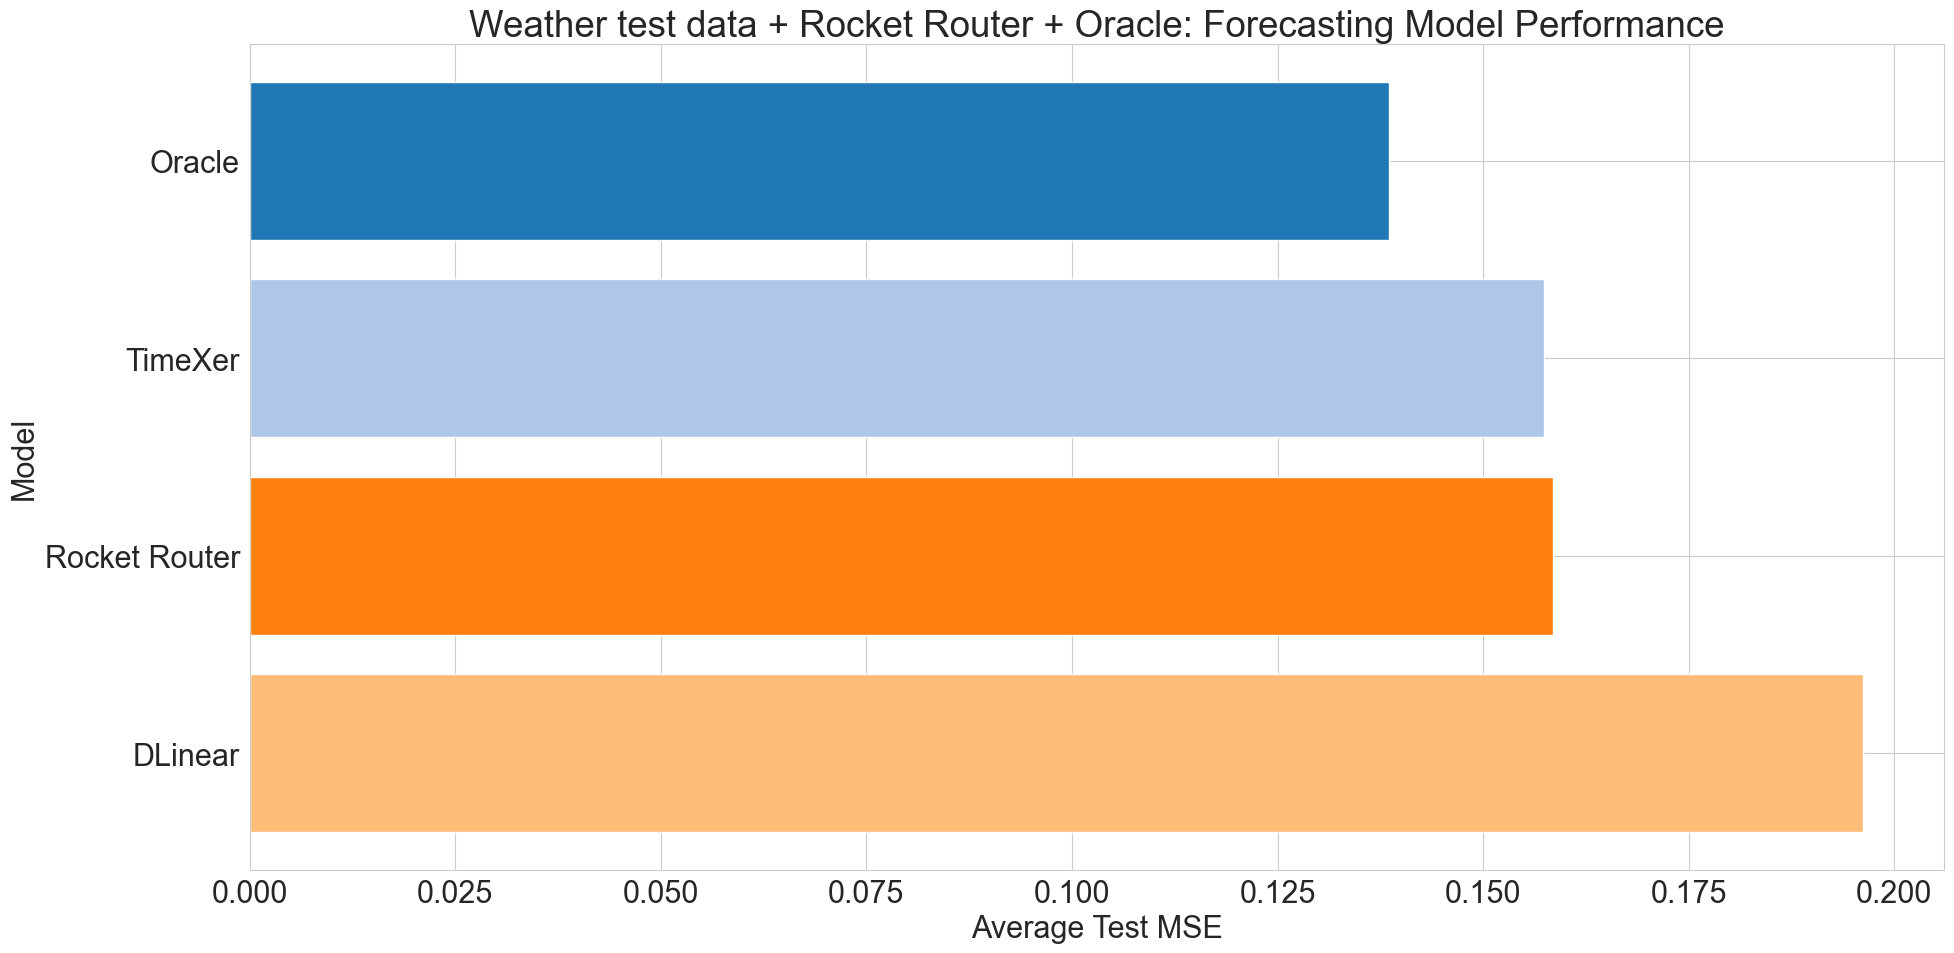

In [ ]:
print("WEATHER")
print_metrics_matrix(weather_test_data_with_rocket)
# print("ETT")
# print_metrics_matrix(ett_test_data_with_rocket)
# print("EXCHANGE")
# print_metrics_matrix(exchange_test_data_with_rocket)

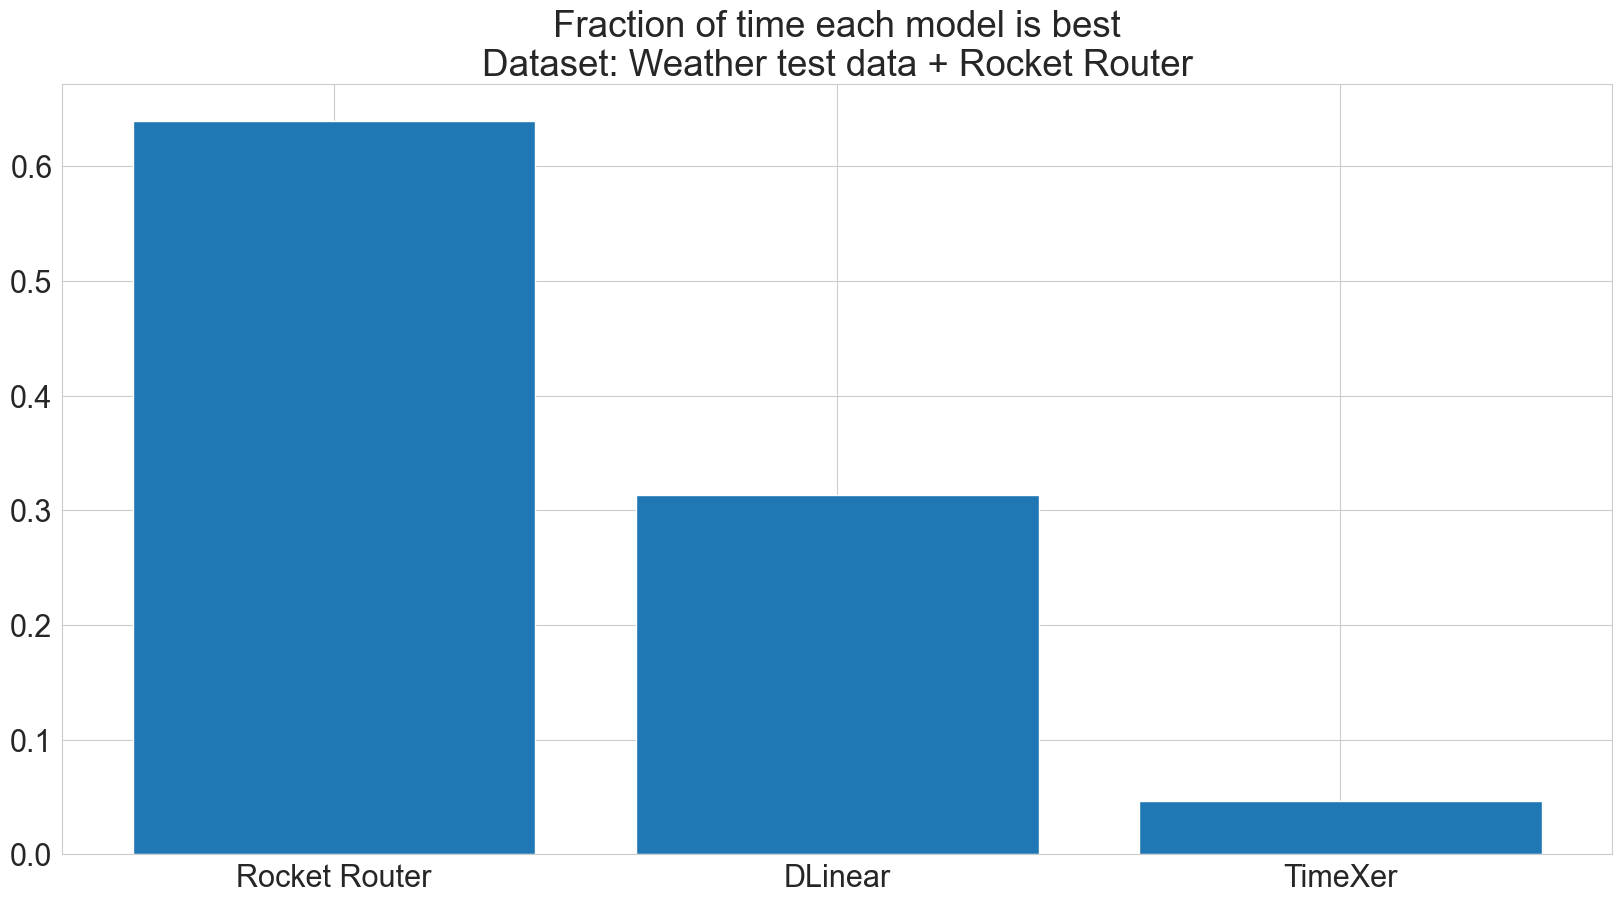

In [ ]:
plot_mse_per_slice(weather_test_data_with_rocket)
# plot_mse_per_slice(ett_test_data_with_rocket)
# plot_mse_per_slice(exchange_test_data_with_rocket)

<h2> Ranking the models with a neural networks </h2> 

In [ ]:
from torch.utils.data import Dataset, DataLoader


class CLSTorchDataset(Dataset):
    def __init__(self, cls_data: CLSData):
        self.cls_data = cls_data
        self.n_models, self.n_slices, self.seq_len, self.n_feats = cls_data.preds.shape

    def __len__(self):
        return self.n_slices

    def __getitem__(self, idx: int):
        x = self.cls_data.x[idx].T
        y = self.cls_data.y[idx].T
        preds = self.cls_data.preds[:, idx].transpose(0, 2, 1)
        mse = self.cls_data.mse[:, idx]
        relevance = self.cls_data.mse[:, idx, :].shape[0] - \
            self.cls_data.mse[:, idx, :].argsort(0).argsort(0)
        error_lag = self.cls_data.error_lag[:, idx].transpose(0, 2, 1)  # .T

        return {
            "x": x,
            "y": y,
            "preds": preds,
            "mse": mse,
            "relevance": relevance,
            "error_lag": error_lag
        }


dataset = CLSTorchDataset(weather_train_data)
dataset.seq_len

96

In [ ]:
sample = dataset[0]

(2, 21, 96)
(2, 21, 96)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Normalize(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        x = x.permute(0, 2, 1)
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        x = x.permute(0, 2, 1)
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(
            torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


class MultiHeadAttention(nn.Module):

    def __init__(
            self,
            d,
            num_heads=4):
        super().__init__()

        self.num_heads = num_heads
        self.W = nn.Linear(d, 3*d)
        self.proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(0.2)
        self.norm = nn.LayerNorm(d)

        self.scale = (d // num_heads) ** -0.5

    def forward(self, x):

        b, s, d = x.shape
        q, k, v = self.W(x).chunk(3, dim=-1)
        q, k, v = (z.reshape(b, s, self.num_heads, d//self.num_heads).transpose(1, 2)
                   for z in (q, k, v))

        attn = torch.einsum("bhqd,bhkd->bhqk", q, k) * self.scale
        attn_weights = F.softmax(attn, dim=-1)

        attn_logits = attn_weights @ v
        out = self.proj(attn_logits.transpose(1, 2).contiguous().view(b, s, d))
        out = self.dropout(out)

        return self.norm(x + out)


class MLP(nn.Module):

    def __init__(self, d):
        super().__init__()

        self.norm = nn.LayerNorm(d)
        self.mlp = nn.Sequential(
            nn.Linear(d, d),
            nn.ReLU(),
            nn.Linear(d, d),
            nn.Dropout(0.2)
        )

    def forward(self, x):

        return self.norm(self.mlp(x) + x)

In [ ]:
def logistic_loss(scores: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    mask = torch.where(labels[:, :, None] - labels[:, None, :] > 0, 1, 0)
    diffs = scores[:, :, None] - scores[:, None, :]
    losses = mask * torch.log(1 + torch.exp(-diffs))
    return losses.mean()

In [ ]:
@dataclass
class ModelInput:
    x: torch.Tensor
    y: torch.Tensor
    preds: torch.Tensor
    mse: torch.Tensor
    relevance: torch.Tensor
    error_lag: torch.Tensor


@dataclass
class ModelOutput:
    logits: torch.Tensor
    preds: torch.Tensor
    loss: torch.Tensor


@dataclass
class ModelConfig:
    d_model: int = 256
    seq_len: int = 96
    n_models: int = 7

In [ ]:
class SimpleMLPModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.proj = nn.Linear(config.seq_len, config.d_model)
        self.mlp = MLP(config.d_model)
        self.head = nn.Linear(config.d_model, config.n_models)


    def forward(self, inp: ModelInput):
        bsz, n_feat, _ = inp.x.shape
        x_ = self.proj(inp.x)
        x_ = self.mlp(x_)
        logits = self.head(x_)
        preds = logits.argmax(-1)
        loss = logistic_loss(logits.reshape(bsz, -1),
                             inp.relevance.reshape(bsz, -1))
        logits = logits.reshape(bsz, n_feat, -1)
        preds = logits.argmax(-1)

        return ModelOutput(logits, preds, loss)

In [ ]:
class TemporalTransformerModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.patch_size = config.seq_len // 8
        self.n_heads = 8
        self.n_layers = 1

        self.config = config
        self.n_patches = config.seq_len // self.patch_size

        self.norm = Normalize(1, affine=False)
        self.proj = nn.Linear(self.patch_size, config.d_model)
        
        self.transformer = nn.ModuleList([
            nn.Sequential(
                MultiHeadAttention(config.d_model, self.n_heads),
                MLP(config.d_model),
            )
            for _ in range(self.n_layers)
        ])

        self.transformer = nn.Sequential(*self.transformer)
        self.head = nn.Linear(config.d_model, config.n_models)

    def forward(self, inp: ModelInput) -> ModelOutput:
        bsz, n_feat, _ = inp.x.shape
        x_ = inp.x.reshape(-1, 1, self.config.seq_len)
        x_ = self.norm(x_, mode="norm")
        x_ = x_.reshape(-1, self.n_patches, self.patch_size)
        x_ = self.proj(x_)
        z = self.transformer(x_)
        logits = self.head(z.mean(1))

        preds = logits.argmax(-1)
        loss = logistic_loss(logits.reshape(bsz, -1),
                             inp.relevance.reshape(bsz, -1))
        logits = logits.reshape(bsz, n_feat, -1)
        preds = logits.argmax(-1)

        return ModelOutput(logits, preds, loss)

In [ ]:
class MLPModel(nn.Module):

    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.embed = nn.Embedding(config.n_models, config.d_model)
        self.norm = Normalize(1, affine=False)
        self.ts_proj = nn.Linear(config.seq_len, config.d_model)
        self.mlp = MLP(config.d_model)
        self.head = nn.Linear(config.d_model, 1)


    def forward(self, inp: ModelInput):
        bsz, n_feat, _ = inp.x.shape
        x_ = inp.x.reshape(-1, 1, self.config.seq_len)
        x_ = self.norm(x_, mode="norm")
        x_ = self.ts_proj(x_)
        c = x_ + self.embed.weight
        z = self.mlp(c)
        logits = self.head(z).squeeze(-1)
        loss = logistic_loss(logits.reshape(bsz, -1),inp.relevance.reshape(bsz, -1))
        logits = logits.reshape(bsz, n_feat, -1)
        preds = logits.argmax(-1)

        return ModelOutput(logits, preds, loss)

In [ ]:
class ResidualConv1D(nn.Module):

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            drop: float = 0.1,
            norm: bool = True
    ):
        super().__init__()

        padding = (kernel_size - 1) // 2

        self.block = nn.Sequential(
            nn.Conv1d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding),
            nn.ReLU(),
            nn.Conv1d(out_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding),
            nn.Dropout(drop)
        )

        self.norm = nn.BatchNorm1d(out_channels) if norm else nn.Identity()
        self.rs = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.norm(self.block(x) + self.rs(x))


class CNNModel(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config

        self.norm = Normalize(1, affine=False)

        self.encoder = nn.Sequential(
            ResidualConv1D(1, 32, 5, 1),
            nn.Conv1d(32, 64, 3, 2, 1),
            ResidualConv1D(64, 64, 5, 1),
            nn.Conv1d(64, 128, 3, 2, 1),
            nn.ReLU(),
            # nn.MaxPool1d(2),
            nn.Conv1d(128, 128, 1)
        )

        self.head = nn.Linear(256*12, config.n_models)

    def forward(self, inp: ModelInput) -> ModelOutput:
        bsz, n_feat, _ = inp.x.shape
        # x_ = inp.x.reshape(-1, 1, self.config.seq_len)
        # print(inp.error_lag.shape)
        error_residual = (inp.error_lag[:, 0] - inp.error_lag[:, 1])
        # err_ = inp.error_lag.permute(0, 2, 1, 3).reshape(-1, self.config.n_models, self.config.seq_len)
        x_ = error_residual.reshape(-1, 1, self.config.seq_len)
        # x_ = torch.cat((x_, err_), 1)
        x_ = self.norm(x_, mode="norm")
        # mu = x_.mean(-1)[:, :, None]
        # std = x_.std(-1)[:, :, None]
        # x_ = (x_ - mu) / (std + 1e-5)
        x_ = self.encoder(x_)
        logits = self.head(x_.flatten(1))
        preds = logits.argmax(-1)
        loss = logistic_loss(logits.reshape(bsz, -1), inp.relevance.reshape(bsz, -1))
        # loss = F.cross_entropy(logits, inp.relevance.argmax(1))
        logits = logits.reshape(bsz, n_feat, -1)
        preds = logits.argmax(-1)

        return ModelOutput(logits, preds, loss)

In [ ]:
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch
from pathlib import Path


@dataclass
class ModelRankingArgs:
    lr: float
    n_epochs: int
    batch_size: int
    out_dir: Path = Path("ranking_results")


class ModelRankingExperiment:
    def __init__(
            self,
            args: ModelRankingArgs,
            cfg: ModelConfig,
            model_name: str,
            train_data: CLSData,
            val_data: CLSData,
            test_data: CLSData):

        self.args = args
        self.test_data_raw = test_data
        self.train_data = CLSTorchDataset(train_data)
        self.val_data = CLSTorchDataset(val_data)
        self.test_data = CLSTorchDataset(test_data)
        self.train_loader = DataLoader(
            self.train_data, batch_size=args.batch_size, shuffle=True)
        self.val_loader = DataLoader(
            self.val_data, batch_size=args.batch_size, shuffle=False)
        self.test_loader = DataLoader(
            self.test_data, batch_size=args.batch_size, shuffle=False)

        if model_name == "mlp":
            self.model = MLPModel(cfg)
        elif model_name == "temporal_transformer":
            self.model = TemporalTransformerModel(cfg)
        elif model_name == "simple_mlp":
            self.model = SimpleMLPModel(cfg)
        elif model_name == "cnn":
            self.model = CNNModel(cfg)
        else:
            raise ValueError(f"Model name {model_name} not recognized")

        self.device = "cuda" if torch.cuda.is_available(
        ) else "mps" if torch.backends.mps.is_available() else "cpu"
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, "min", patience=10, factor=0.1)

        self.args.out_dir.mkdir(parents=True, exist_ok=True)
        self.best_model_path = self.args.out_dir / "best_model.pt"
        self.best_val_loss = float('inf')

    def validate(self, loader, desc="Validating"):
        val_loss = 0
        val_labels, val_preds = [], []
        val_scores = []

        with torch.no_grad():
            self.model.eval()
            for batch in tqdm(loader, desc=desc):
                inp = ModelInput(
                    x=batch["x"].to(self.device),
                    y=batch["y"].to(self.device),
                    preds=batch["preds"].to(self.device),
                    mse=batch["mse"].to(self.device),
                    relevance=batch["relevance"].to(self.device),
                    error_lag=batch["error_lag"].to(self.device),
                )
                out = self.model(inp)
                loss = out.loss

                val_loss += loss.item()
                val_labels += inp.relevance.argmax(1).flatten().detach().cpu().tolist()
                val_scores += out.logits.reshape(-1, inp.relevance.shape[1]).detach().cpu().tolist()
                val_preds += out.preds.flatten().detach().cpu().tolist()

        val_loss /= len(loader)
        
        top_1_acc = top_k_acc(
            np.array(val_labels), np.array(val_scores), k=1)
        top_2_acc = top_k_acc(
            np.array(val_labels), np.array(val_scores), k=2) 
        top_3_acc = top_k_acc(
            np.array(val_labels), np.array(val_scores), k=3)

        return {
            'loss': val_loss,
            'top_1_acc': top_1_acc,
            'top_2_acc': top_2_acc,
            'top_3_acc': top_3_acc,
            'labels': val_labels,
            'preds': val_preds,
            'scores': val_scores
        }

    def run(self):
        train_losses = []
        val_losses = []

        for epoch in range(self.args.n_epochs):
            print(f"\nEPOCH {epoch+1}/{self.args.n_epochs}")

            self.model.train()
            train_loss = 0
            pbar = tqdm(self.train_loader, desc="Training")
            for batch in pbar:
                inp = ModelInput(
                    x=batch["x"].to(self.device),
                    y=batch["y"].to(self.device),
                    preds=batch["preds"].to(self.device),
                    mse=batch["mse"].to(self.device),
                    relevance=batch["relevance"].to(self.device),
                    error_lag=batch["error_lag"].to(self.device),
                )
                out = self.model(inp)
                loss = out.loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

            train_loss /= len(self.train_loader)
            train_losses.append(train_loss)

            val_results = self.validate(self.val_loader, desc="Validating")
            val_loss = val_results['loss']
            val_losses.append(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Top-1 Acc: {val_results['top_1_acc']:.4f}, "
                  f"Top-2 Acc: {val_results['top_2_acc']:.4f}, "
                  f"Top-3 Acc: {val_results['top_3_acc']:.4f}")

            self.lr_scheduler.step(val_loss)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.best_model_path)
                print(f"Saved best model with val loss: {val_loss:.4f}")

        print("\n" + "="*50)
        print("Training complete. Loading best model for test evaluation...")
        print("="*50)

        self.model.load_state_dict(torch.load(
            self.best_model_path, map_location=self.device))

        print("\nEvaluating on test set...")
        test_results = self.validate(self.test_loader, desc="Testing")

        print(f"\n{'='*50}")
        print("TEST SET RESULTS")
        print(f"{'='*50}")
        print(f"Test Loss: {test_results['loss']:.4f}")
        print(f"Top-1 Accuracy: {test_results['top_1_acc']:.4f}")
        print(f"Top-2 Accuracy: {test_results['top_2_acc']:.4f}")
        print(f"Top-3 Accuracy: {test_results['top_3_acc']:.4f}")
        print("\nClassification Report:")
        report = classification_report(
            test_results["labels"], test_results["preds"])
        print(report)

        n_slices, _, n_feats = self.test_data_raw.x.shape
        test_predicted_best_idx = np.array(test_results["preds"]).reshape(n_slices, n_feats)
        test_routed_forecasts = select_preds_from_idx(test_predicted_best_idx, self.test_data_raw.preds)
        return CLSOutput(test_predicted_best_idx, test_routed_forecasts)

In [ ]:
weather_ranking_args = ModelRankingArgs(
    lr=0.001,
    n_epochs=5,
    batch_size=32,
    out_dir=Path("ranking_results") / "weather"
)
weather_ranking_cfg = ModelConfig(n_models=2)

weather_ranking_exp_cnn = ModelRankingExperiment(weather_ranking_args, weather_ranking_cfg, "cnn", weather_train_data, weather_val_data, weather_test_data)
print("WEATHER - RUNNING CNN")
weather_ranking_cnn_output = weather_ranking_exp_cnn.run()

# weather_ranking_exp_mlp = ModelRankingExperiment(weather_ranking_args, weather_ranking_cfg, "mlp", weather_train_data, weather_val_data, weather_test_data)
#print("WEATHER - RUNNING MLP")
# weather_ranking_mlp_output = weather_ranking_exp_mlp.run()

# weather_ranking_exp_temporal_transformer = ModelRankingExperiment(weather_ranking_args, weather_ranking_cfg, "temporal_transformer", weather_train_data, weather_val_data, weather_test_data)
# print("WEATHER - RUNNING TEMPORAL TRANSFORMER")
# weather_ranking_temporal_transformer_output = weather_ranking_exp_temporal_transformer.run()

WEATHER - RUNNING CNN

EPOCH 1/5


Training:   0%|          | 0/1147 [00:00<?, ?it/s]

Validating: 100%|██████████| 162/162 [00:01<00:00, 83.72it/s] 


Train Loss: 0.1564, Val Loss: 0.1557, Top-1 Acc: 0.5898, Top-2 Acc: 1.0000, Top-3 Acc: 1.0000
Saved best model with val loss: 0.1557

EPOCH 2/5


Validating: 100%|██████████| 162/162 [00:01<00:00, 103.87it/s]


Train Loss: 0.1478, Val Loss: 0.1512, Top-1 Acc: 0.6137, Top-2 Acc: 1.0000, Top-3 Acc: 1.0000
Saved best model with val loss: 0.1512

EPOCH 3/5


Validating: 100%|██████████| 162/162 [00:01<00:00, 96.16it/s]


Train Loss: 0.1434, Val Loss: 0.1522, Top-1 Acc: 0.6100, Top-2 Acc: 1.0000, Top-3 Acc: 1.0000

EPOCH 4/5


Validating: 100%|██████████| 162/162 [00:01<00:00, 82.39it/s]


Train Loss: 0.1394, Val Loss: 0.1521, Top-1 Acc: 0.5919, Top-2 Acc: 1.0000, Top-3 Acc: 1.0000

EPOCH 5/5


Validating: 100%|██████████| 162/162 [00:01<00:00, 93.95it/s]


Train Loss: 0.1359, Val Loss: 0.1510, Top-1 Acc: 0.5714, Top-2 Acc: 1.0000, Top-3 Acc: 1.0000
Saved best model with val loss: 0.1510

Training complete. Loading best model for test evaluation...

Evaluating on test set...


Testing: 100%|██████████| 327/327 [00:03<00:00, 85.63it/s]



TEST SET RESULTS
Test Loss: 0.1668
Top-1 Accuracy: 0.5311
Top-2 Accuracy: 1.0000
Top-3 Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.58      0.46     76446
           1       0.69      0.50      0.58    142878

    accuracy                           0.53    219324
   macro avg       0.54      0.54      0.52    219324
weighted avg       0.59      0.53      0.54    219324



In [ ]:
# ett_ranking_args = ModelRankingArgs(
#     lr=0.001,
#     n_epochs=5,
#     batch_size=32,
#     out_dir=Path("ranking_results") / "ett"
# )
# ett_ranking_cfg = ModelConfig()

# ett_ranking_exp_mlp = ModelRankingExperiment(ett_ranking_args, ett_ranking_cfg, "mlp", ett_train_data, ett_val_data, ett_test_data)
# print("ETT - RUNNING MLP")
# ett_ranking_mlp_output = ett_ranking_exp_mlp.run()

# ett_ranking_exp_temporal_transformer = ModelRankingExperiment(ett_ranking_args, ett_ranking_cfg, "temporal_transformer", ett_train_data, ett_val_data, ett_test_data)
# print("ETT - RUNNING TEMPORAL TRANSFORMER")
# ett_ranking_temporal_transformer_output = ett_ranking_exp_temporal_transformer.run()


In [ ]:
# exchange_ranking_args = ModelRankingArgs(
#     lr=0.001,
#     n_epochs=5,
#     batch_size=32,
#     out_dir=Path("ranking_results") / "exchange"
# )
# exchange_ranking_cfg = ModelConfig()

# exchange_ranking_exp_mlp = ModelRankingExperiment(exchange_ranking_args, exchange_ranking_cfg, "mlp", exchange_train_data, exchange_val_data, exchange_test_data)
# print("EXCHANGE - RUNNING MLP")
# exchange_ranking_mlp_output = exchange_ranking_exp_mlp.run()

# exchange_ranking_exp_temporal_transformer = ModelRankingExperiment(exchange_ranking_args, exchange_ranking_cfg, "temporal_transformer", exchange_train_data, exchange_val_data, exchange_test_data)
# print("EXCHANGE - RUNNING TEMPORAL TRANSFORMER")
# exchange_ranking_temporal_transformer_output = exchange_ranking_exp_temporal_transformer.run()

Weather test data + Rocket Router + MLP Router + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.1447     0.1917
TimeXer             0.1574     0.2047
MLP Router          0.1584     0.2056
Rocket Router       0.1587     0.2055
TimeMixer           0.1623     0.2096


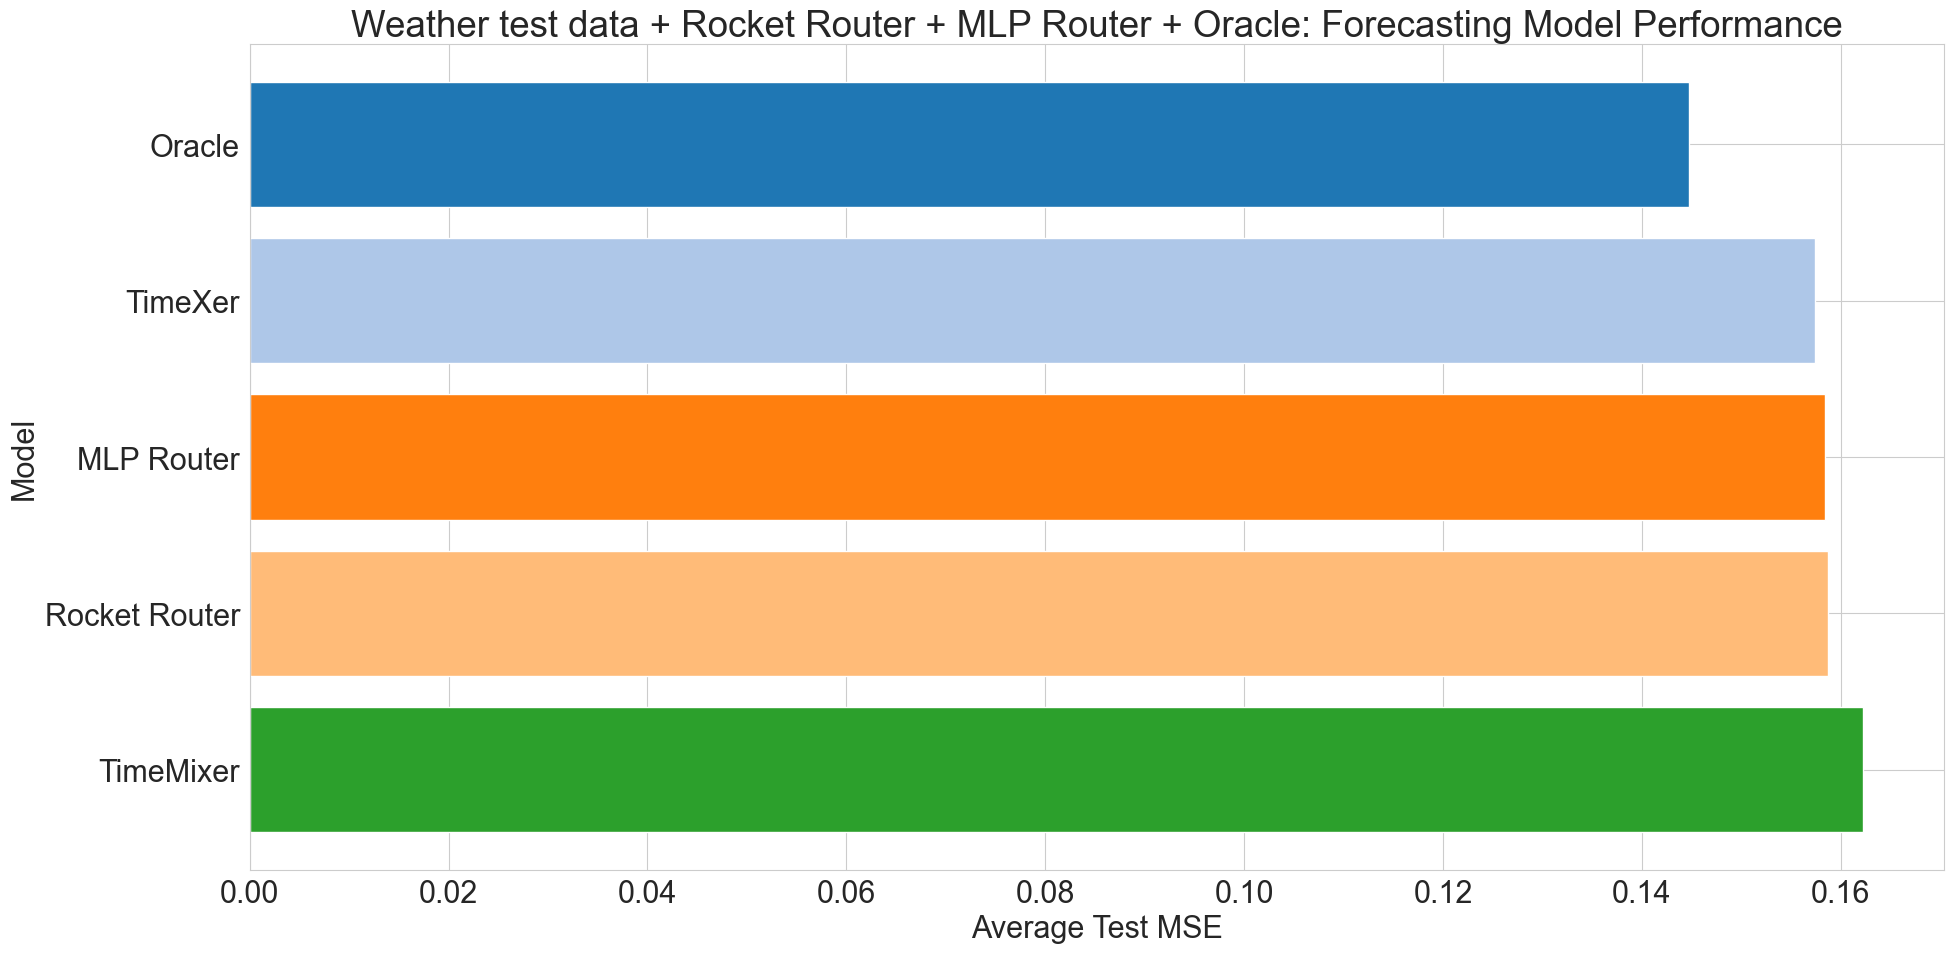

In [ ]:
weather_test_data_complete = add_model_to_cls_data(
    weather_ranking_mlp_output.routed_forecasts, "MLP Router", weather_test_data_with_rocket)
# weather_test_data_complete = add_model_to_cls_data(
#     weather_ranking_temporal_transformer_output.routed_forecasts, "Transformer Router", weather_test_data_complete)
print_metrics_matrix(weather_test_data_complete)

    
# ett_test_data_complete = add_model_to_cls_data(
#     ett_ranking_mlp_output.routed_forecasts, "MLP Router", ett_test_data_with_rocket)
# ett_test_data_complete = add_model_to_cls_data(
#     ett_ranking_temporal_transformer_output.routed_forecasts, "Transformer Router", ett_test_data_complete)
# print_metrics_matrix(ett_test_data_complete)

# exchange_test_data_complete = add_model_to_cls_data(
#     exchange_ranking_mlp_output.routed_forecasts, "MLP Router", exchange_test_data_with_rocket)
# exchange_test_data_complete = add_model_to_cls_data(
#     exchange_ranking_temporal_transformer_output.routed_forecasts, "Transformer Router", exchange_test_data_complete)
# print_metrics_matrix(exchange_test_data_complete)